# Let's go!

## Imports

In [22]:
import normflows as nf
import matplotlib.pyplot as plt
import torch
import numpy as np

from fab import FABModel, HamiltonianMonteCarlo, Metropolis
from fab.utils.logging import ListLogger
from fab.utils.plotting import plot_history, plot_contours, plot_marginal_pair
from fab.target_distributions.gmm import GMM
from fab.utils.prioritised_replay_buffer import PrioritisedReplayBuffer
from fab import Trainer, PrioritisedBufferTrainer
from fab.utils.plotting import plot_contours, plot_marginal_pair
from tqdm import tqdm,trange
import scipy.stats.qmc as qmc
from experiments.make_flow import make_wrapped_normflow_realnvp
import pandas as pd

## Setup Target distribution

In [2]:
dim = 2
n_mixes = 40
loc_scaling = 40.0  # scale of the problem (changes how far apart the modes of each Guassian component will be)
log_var_scaling = 1.0 # variance of each Gaussian
seed = 1

In [3]:
torch.manual_seed(0)  # seed of 0 for GMM problem
target = GMM(dim=dim, n_mixes=n_mixes,
              loc_scaling=loc_scaling, log_var_scaling=log_var_scaling,
              use_gpu=True, true_expectation_estimation_n_samples=int(1e5))

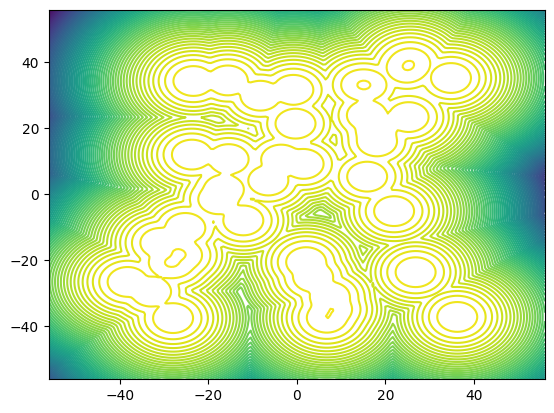

In [4]:
# plot target
target.to("cpu")
fig, ax = plt.subplots()
plotting_bounds = (-loc_scaling * 1.4, loc_scaling * 1.4)
plot_contours(target.log_prob, bounds=plotting_bounds, n_contour_levels=80, ax=ax, grid_width_n_points=200)
target.to("cuda")

## Create FAB model

In [5]:
# hyper-parameters

# Flow
n_flow_layers = 15
layer_nodes_per_dim = 40
lr = 1e-4
max_gradient_norm = 100.0
batch_size = 128
n_iterations = 4000
n_eval = 10
eval_batch_size = batch_size * 10
n_plots = 10 # number of plots shows throughout tranining
use_64_bit = True
alpha = 2.0

# AIS
# By default we use a simple metropolis mcmc transition with a fixed step size.
# Can switch this to 'hmc' to improve training efficiency. 
transition_operator_type = "metropolis" 
n_intermediate_distributions = 1
metropolis_step_size = 5.0

# buffer config
n_batches_buffer_sampling = 4
maximum_buffer_length = batch_size * n_batches_buffer_sampling * 100
min_buffer_length = batch_size * n_batches_buffer_sampling * 10

# target p^\alpha q^{a-\alpha} as target for AIS. 
min_is_target = True
p_target = not min_is_target # Whether to use p as the target. 

In [6]:
if use_64_bit:
    torch.set_default_dtype(torch.float64)
    target = target.double()
    print(f"running with 64 bit")

running with 64 bit


### Setup flow

In [7]:
flow = make_wrapped_normflow_realnvp(dim, n_flow_layers=n_flow_layers, 
                                 layer_nodes_per_dim=layer_nodes_per_dim,
                                act_norm = False)

/Users/andral/.pyenv/versions/3.10.12/envs/QMC_flow_AISTATS/lib/python3.10/site-packages/torch/_tensor.py:677: UserWarning: torch.lu is deprecated in favor of torch.linalg.lu_factor / torch.linalg.lu_factor_ex and will be removed in a future PyTorch release.
LU, pivots = torch.lu(A, compute_pivots)
should be replaced with
LU, pivots = torch.linalg.lu_factor(A, compute_pivots)
and
LU, pivots, info = torch.lu(A, compute_pivots, get_infos=True)
should be replaced with
LU, pivots, info = torch.linalg.lu_factor_ex(A, compute_pivots) (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:2001.)
  LU, pivots, infos = torch._lu_with_info(


### Setup Transition operator

In [8]:
if transition_operator_type == "hmc":
    # very lightweight HMC.
    transition_operator = HamiltonianMonteCarlo(
            n_ais_intermediate_distributions=n_intermediate_distributions,
            dim=dim,
            base_log_prob=flow.log_prob,
            target_log_prob=target.log_prob,
            alpha=alpha,
            p_target=p_target,
        n_outer=1,
        epsilon=1.0, L=5)
elif transition_operator_type == "metropolis":
    transition_operator = Metropolis(            
        n_ais_intermediate_distributions=n_intermediate_distributions,
        dim=dim,
        base_log_prob=flow.log_prob,
        target_log_prob=target.log_prob,
        p_target=p_target,
        alpha=alpha,
        n_updates=1,
        adjust_step_size=False,
        max_step_size=metropolis_step_size, # the same for all metropolis steps 
        min_step_size=metropolis_step_size,
        eval_mode=False,
                                  )
else:
    raise NotImplementedError

### Setup FAB model with prioritised replay buffer

In [9]:
# use GPU if available
if torch.cuda.is_available():
    flow.cuda()
    transition_operator.cuda()
    target.to("cuda")
    print(f"Running with GPU")

In [10]:
fab_model = FABModel(flow=flow,
                     target_distribution=target,
                     n_intermediate_distributions=n_intermediate_distributions,
                     transition_operator=transition_operator,
                     alpha=alpha)
optimizer = torch.optim.Adam(flow.parameters(), lr=lr)
logger = ListLogger(save=False) # save training history

In [11]:
# Setup buffer.
def initial_sampler():
  # fill replay buffer using initialised model and AIS.
    point, log_w = fab_model.annealed_importance_sampler.sample_and_log_weights(
            batch_size, logging=False)
    return point.x, log_w, point.log_q
buffer = PrioritisedReplayBuffer(dim=dim, max_length=maximum_buffer_length,
                      min_sample_length=min_buffer_length,
                      initial_sampler=initial_sampler)

In [12]:
def plot(fab_model, n_samples = 128):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    target.to("cpu")
    plot_contours(target.log_prob, bounds=plotting_bounds, ax=axs[0], n_contour_levels=50, grid_width_n_points=200)
    plot_contours(target.log_prob, bounds=plotting_bounds, ax=axs[1], n_contour_levels=50, grid_width_n_points=200)
    plot_contours(target.log_prob, bounds=plotting_bounds, ax=axs[2], n_contour_levels=50, grid_width_n_points=200)
    target.to("cuda")

    # plot flow samples
    samples_flow = fab_model.flow.sample((n_samples,)).detach()
    plot_marginal_pair(samples_flow, ax=axs[0], bounds=plotting_bounds)


    # plot ais samples
    samples_ais = fab_model.annealed_importance_sampler.sample_and_log_weights(n_samples,
                                                                               logging=False)[0].x
    plot_marginal_pair(samples_ais, ax=axs[1], bounds=plotting_bounds)
    
    # plot buffer samples
    samples_buffer = buffer.sample(n_samples)[0].detach()
    plot_marginal_pair(samples_buffer, ax=axs[2], bounds=plotting_bounds)
    
    axs[0].set_title("flow samples")
    axs[1].set_title("ais samples")
    axs[2].set_title("buffer samples")
    plt.show()
    return [fig]

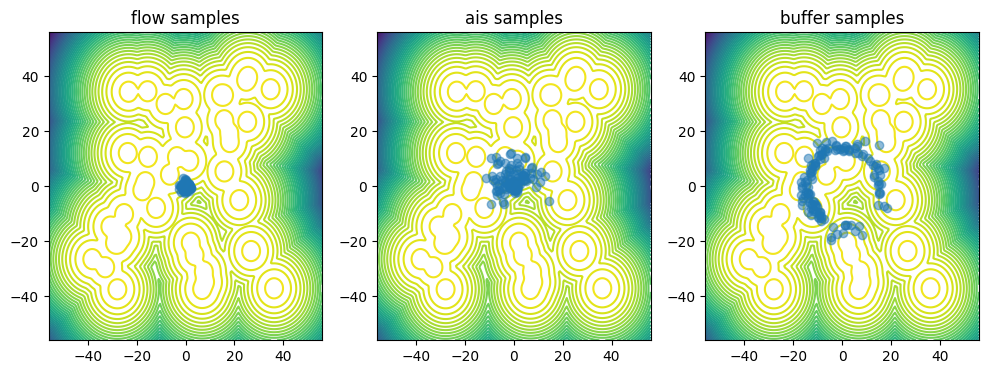

[<Figure size 1200x400 with 3 Axes>]

In [13]:
plot(fab_model) # Visualise model during initialisation.

In [14]:
# Setup trainer.
trainer = PrioritisedBufferTrainer(model=fab_model, optimizer=optimizer, 
              logger=logger, plot=plot,
              buffer=buffer, 
              n_batches_buffer_sampling=n_batches_buffer_sampling,
              max_gradient_norm=max_gradient_norm,
              alpha=alpha,
              w_adjust_max_clip=None)

## Train model

This problem is quite challenging for training, as the flow has a very poor initialisation, and therefore often places extremely small probability on samples in new modes.

This causes some **numerical instability**: There are lots of NaN errors throughout training, due to (1) numerical sinstability in the flow itself causing the flow to generate NaN samples or samples with large values that have NaN log prob under the target, as well as (2) sometimes AIS finds regions in the target with negligible mass under the flow.  However, these numerical instabilities do not prevent training from suceeding. 

loss: 0.022802660857067315, ess base: 0.02436022634834733,ess ais: 0.0078125:   0%|          | 0/4000 [00:00<?, ?it/s]/Users/andral/.pyenv/versions/3.10.12/envs/QMC_flow_AISTATS/lib/python3.10/site-packages/fab/utils/numerical.py:59: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3575.)
  expectation = normalised_importance_weights.T @ function_values


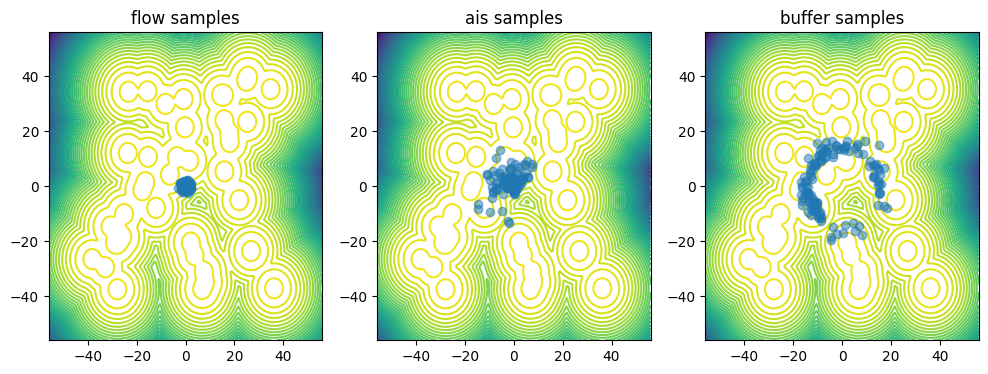

loss: 5.311449203775154, ess base: 0.02859539118210139,ess ais: 0.017711442896423665:   1%|          | 23/4000 [00:02<03:40, 18.05it/s]     

1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 6.169621961219358, ess base: 0.06945897624044267,ess ais: 0.019492985042184042:   1%|          | 28/4000 [00:02<03:34, 18.52it/s]  

5 nan/inf samples/log-probs/log-weights encountered at chain init.
5 nan/inf samples/log-probs/log-weights encountered at chain init.
6 nan/inf samples/log-probs/log-weights encountered at chain init.
9 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 5.955411109188383, ess base: 0.06083662398099114,ess ais: 0.019824585143320726:   1%|          | 32/4000 [00:02<03:27, 19.09it/s] 

8 nan/inf samples/log-probs/log-weights encountered at chain init.
4 nan/inf samples/log-probs/log-weights encountered at chain init.
8 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 6.379470183068893, ess base: 0.045235848087316524,ess ais: 0.0140329860292698:   1%|          | 37/4000 [00:02<03:21, 19.67it/s]  

5 nan/inf samples/log-probs/log-weights encountered at chain init.
5 nan/inf samples/log-probs/log-weights encountered at chain init.
6 nan/inf samples/log-probs/log-weights encountered at chain init.
4 nan/inf samples/log-probs/log-weights encountered at chain init.
6 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 6.331513134676686, ess base: 0.054605299210126246,ess ais: 0.028640888066116997:   1%|          | 40/4000 [00:03<03:19, 19.84it/s] 

5 nan/inf samples/log-probs/log-weights encountered at chain init.
4 nan/inf samples/log-probs/log-weights encountered at chain init.
7 nan/inf samples/log-probs/log-weights encountered at chain init.
4 nan/inf samples/log-probs/log-weights encountered at chain init.
4 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 6.457062818189669, ess base: 0.10509485048599819,ess ais: 0.017618093982759632:   1%|          | 46/4000 [00:03<03:15, 20.21it/s] 

4 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
5 nan/inf samples/log-probs/log-weights encountered at chain init.
10 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 6.69207629028808, ess base: 0.0788987863814718,ess ais: 0.02340058124454777:   1%|▏         | 52/4000 [00:03<03:15, 20.17it/s]    

3 nan/inf samples/log-probs/log-weights encountered at chain init.
5 nan/inf samples/log-probs/log-weights encountered at chain init.
7 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
5 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 6.954889662553895, ess base: 0.09620098856450632,ess ais: 0.030827097952787864:   1%|▏         | 55/4000 [00:03<03:15, 20.18it/s] 

3 nan/inf samples/log-probs/log-weights encountered at chain init.
6 nan/inf samples/log-probs/log-weights encountered at chain init.
6 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.036272164589915, ess base: 0.06522201993187565,ess ais: 0.012507366077822497:   2%|▏         | 61/4000 [00:04<03:15, 20.11it/s]

7 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.
4 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.1959009783695205, ess base: 0.10897109257190775,ess ais: 0.025468588615129992:   2%|▏         | 67/4000 [00:04<03:17, 19.88it/s]

8 nan/inf samples/log-probs/log-weights encountered at chain init.
4 nan/inf samples/log-probs/log-weights encountered at chain init.
4 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.144637544727612, ess base: 0.01855691593180785,ess ais: 0.008382664550504798:   2%|▏         | 69/4000 [00:04<03:20, 19.62it/s] 

2 nan/inf samples/log-probs/log-weights encountered at chain init.
4 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.
4 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.269522440812432, ess base: 0.15563179896263507,ess ais: 0.03900185625666414:   2%|▏         | 75/4000 [00:04<03:20, 19.61it/s]  

6 nan/inf samples/log-probs/log-weights encountered at chain init.
5 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
4 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.1400647171432166, ess base: 0.010931701081877226,ess ais: 0.008164614814275455:   2%|▏         | 77/4000 [00:04<03:40, 17.80it/s]

4 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
5 nan/inf samples/log-probs/log-weights encountered at chain init.
5 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.321759672693449, ess base: 0.2081261117551229,ess ais: 0.07478095766949656:   2%|▏         | 83/4000 [00:05<03:24, 19.14it/s]    

3 nan/inf samples/log-probs/log-weights encountered at chain init.
5 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
6 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.789772143688335, ess base: 0.15849347224938665,ess ais: 0.0375001156778685:   2%|▏         | 86/4000 [00:05<03:21, 19.45it/s]  

4 nan/inf samples/log-probs/log-weights encountered at chain init.
5 nan/inf samples/log-probs/log-weights encountered at chain init.
5 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.7536135075978185, ess base: 0.025719864936133017,ess ais: 0.009108968356517701:   2%|▏         | 92/4000 [00:05<03:17, 19.83it/s]

3 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.536755269703038, ess base: 0.13891541649569755,ess ais: 0.052359547832320344:   2%|▏         | 97/4000 [00:05<03:16, 19.89it/s]  

3 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.684404348615782, ess base: 0.020654828867607108,ess ais: 0.018276017183566536:   3%|▎         | 102/4000 [00:06<03:14, 20.02it/s]

4 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.570717742823446, ess base: 0.15512136301326218,ess ais: 0.0574765494697218:   3%|▎         | 107/4000 [00:06<03:14, 20.03it/s]   

1 nan/inf samples/log-probs/log-weights encountered at chain init.
5 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.698566536072958, ess base: 0.029571405961720622,ess ais: 0.01565853455911631:   3%|▎         | 110/4000 [00:06<03:13, 20.08it/s] 

2 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.7162359643943255, ess base: 0.023249566317863457,ess ais: 0.00835300271150569:   3%|▎         | 115/4000 [00:06<03:18, 19.61it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.
4 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.927260141717345, ess base: 0.042480281727979304,ess ais: 0.010087322025453148:   3%|▎         | 120/4000 [00:07<03:14, 19.96it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.985410077316261, ess base: 0.03813452291191242,ess ais: 0.010187870280485649:   3%|▎         | 125/4000 [00:07<03:13, 20.06it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.734439696506956, ess base: 0.018513756682601763,ess ais: 0.008978783520750062:   3%|▎         | 131/4000 [00:07<03:11, 20.16it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.152340781691523, ess base: 0.21746840532499523,ess ais: 0.0847997739083069:   3%|▎         | 134/4000 [00:07<03:30, 18.35it/s]   

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.04938074515104, ess base: 0.04585500660649103,ess ais: 0.014572735352142617:   3%|▎         | 139/4000 [00:08<03:21, 19.13it/s]  

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.090296385268392, ess base: 0.16229880298106752,ess ais: 0.0542826556155109:   4%|▎         | 145/4000 [00:08<03:15, 19.69it/s]  

4 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.996129252021155, ess base: 0.047823870625694834,ess ais: 0.016444720886790005:   4%|▍         | 150/4000 [00:08<03:13, 19.92it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.132529784221543, ess base: 0.13669552415197644,ess ais: 0.04715240426098578:   4%|▍         | 154/4000 [00:08<03:15, 19.72it/s]  

2 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.960587679102047, ess base: 0.04775570803286051,ess ais: 0.0194924559208043:   4%|▍         | 158/4000 [00:09<03:16, 19.54it/s]  

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.595422967883671, ess base: 0.03591357611499798,ess ais: 0.01620047884519311:   4%|▍         | 164/4000 [00:09<03:12, 19.93it/s] 

2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.55050102733021, ess base: 0.14266242055136535,ess ais: 0.05123101396650094:   4%|▍         | 169/4000 [00:09<03:11, 19.97it/s]  

1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.468263055021428, ess base: 0.06861933379376446,ess ais: 0.012245899563409574:   4%|▍         | 175/4000 [00:09<03:11, 19.99it/s]

3 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.620310459884685, ess base: 0.03075741039225226,ess ais: 0.008775116744356076:   4%|▍         | 180/4000 [00:10<03:11, 19.93it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.53848524356991, ess base: 0.06876930014328053,ess ais: 0.019843116409622392:   5%|▍         | 183/4000 [00:10<03:10, 20.02it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.632541242753982, ess base: 0.14731853603785006,ess ais: 0.07163950658209386:   5%|▍         | 189/4000 [00:10<03:09, 20.12it/s] 

2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
4 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.24396529471699, ess base: 0.08405219509653962,ess ais: 0.02730755737777184:   5%|▍         | 195/4000 [00:10<03:10, 19.93it/s]  

3 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.4302983049942, ess base: 0.09035892582002775,ess ais: 0.018609883592983344:   5%|▌         | 201/4000 [00:11<03:13, 19.65it/s]  

2 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.521523358956529, ess base: 0.15560459624085363,ess ais: 0.07177404047496024:   5%|▌         | 204/4000 [00:11<03:10, 19.88it/s]  

2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.222256814762869, ess base: 0.11096122778171652,ess ais: 0.03618305613127834:   5%|▌         | 210/4000 [00:11<03:07, 20.17it/s]

3 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.72456046628286, ess base: 0.1384941053012588,ess ais: 0.04834673684734553:   5%|▌         | 216/4000 [00:11<03:07, 20.21it/s]   

1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.848350549843346, ess base: 0.1778947923483521,ess ais: 0.08343583538386412:   6%|▌         | 221/4000 [00:12<03:13, 19.54it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.158140865147718, ess base: 0.07582155417662409,ess ais: 0.013793757408642545:   6%|▌         | 226/4000 [00:12<03:11, 19.71it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.638769127523359, ess base: 0.16716072982476543,ess ais: 0.007936507936507936:   6%|▌         | 229/4000 [00:12<03:06, 20.21it/s]

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
2 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 8.479144518266693, ess base: 0.19894661331537014,ess ais: 0.07911197409241781:   6%|▌         | 232/4000 [00:12<03:07, 20.10it/s] 

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 120370536139.84375, ess base: 0.11249933344407989,ess ais: 0.007874015797762072:   6%|▌         | 237/4000 [00:13<03:18, 18.93it/s]

3 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.41878065981981, ess base: 0.06084750028057877,ess ais: 0.00782924759699137:   6%|▌         | 241/4000 [00:13<03:24, 18.40it/s]   

2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.98357801068621, ess base: 0.25965660508067706,ess ais: 0.011356476609519713:   6%|▌         | 247/4000 [00:13<03:21, 18.66it/s] 

2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 9.151155926957356, ess base: 0.20735399702633958,ess ais: 0.09278208731904722:   6%|▋         | 252/4000 [00:13<03:12, 19.44it/s] 

3 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.377757295433746, ess base: 0.05066969968100518,ess ais: 0.011352679515152673:   6%|▋         | 254/4000 [00:14<03:21, 18.63it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 2972780271112938.5, ess base: 0.09596402277803316,ess ais: 0.014993805363207732:   6%|▋         | 258/4000 [00:14<04:26, 14.05it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 9.620412208945162, ess base: 0.1559466261126975,ess ais: 0.007874015748031496:   7%|▋         | 262/4000 [00:14<04:03, 15.37it/s]  

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
4 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.361158084760332, ess base: 0.08822233694980065,ess ais: 0.007874015748031496:   7%|▋         | 266/4000 [00:14<03:45, 16.59it/s]

3 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.703131080917156, ess base: 0.12896244444402508,ess ais: 0.02542721669161356:   7%|▋         | 270/4000 [00:14<03:33, 17.46it/s] 

4 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.359826319772203, ess base: 0.17947854638138916,ess ais: 0.06205561216100451:   7%|▋         | 274/4000 [00:15<03:30, 17.67it/s] 

2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.298376741145756, ess base: 0.1885220990401269,ess ais: 0.0834550822049266:   7%|▋         | 278/4000 [00:15<03:23, 18.30it/s]   

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 9.038365360151547, ess base: 0.11634150054551079,ess ais: 0.025576160546428618:   7%|▋         | 284/4000 [00:15<03:19, 18.65it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.306664137249822, ess base: 0.1419276849058683,ess ais: 0.06560783910500737:   7%|▋         | 290/4000 [00:16<03:13, 19.22it/s]   

3 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 9.21878055886663, ess base: 0.026260381195322608,ess ais: 0.008566779140966381:   7%|▋         | 294/4000 [00:16<03:38, 16.95it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
3 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.69406697324143, ess base: 0.16095901553410197,ess ais: 0.04981564308195883:   7%|▋         | 299/4000 [00:16<03:19, 18.58it/s]  

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.459849283525326, ess base: 0.1970934408001236,ess ais: 0.06631864011960965:   8%|▊         | 304/4000 [00:16<03:11, 19.32it/s] 

4 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 11.32158355326062, ess base: 0.20494820560816002,ess ais: 0.11805846667256317:   8%|▊         | 309/4000 [00:17<03:08, 19.58it/s] 

2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.62770739049655, ess base: 0.20565462684767188,ess ais: 0.07191581168607993:   8%|▊         | 316/4000 [00:17<03:11, 19.26it/s] 

2 nan/inf samples/log-probs/log-weights encountered at chain init.
4 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 9.622001705737187, ess base: 0.20995419736906537,ess ais: 0.1193317369719077:   8%|▊         | 320/4000 [00:17<03:15, 18.86it/s]     

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.257006075435363, ess base: 0.04341765571501396,ess ais: 0.008:   8%|▊         | 325/4000 [00:17<03:08, 19.52it/s]               

3 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.28360601977242, ess base: 0.1505711397973069,ess ais: 0.037958356071609176:   8%|▊         | 330/4000 [00:18<03:05, 19.77it/s]   

3 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.708861366023449, ess base: 0.279371817975535,ess ais: 0.125495836480194:   8%|▊         | 336/4000 [00:18<03:03, 19.98it/s]     

2 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.628358842264245, ess base: 0.14177950138192325,ess ais: 0.04625924197562872:   8%|▊         | 340/4000 [00:18<03:03, 19.94it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 9.080601514002403, ess base: 0.14793749924675817,ess ais: 0.0324962471347078:   9%|▊         | 345/4000 [00:18<03:03, 19.95it/s]   

3 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 9.413709084371197, ess base: 0.21039660905415689,ess ais: 0.10983630814120658:   9%|▉         | 351/4000 [00:19<03:02, 20.03it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.830745932523318, ess base: 0.14394778643547357,ess ais: 0.04588032392421455:   9%|▉         | 354/4000 [00:19<03:01, 20.08it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.930567613408606, ess base: 0.16131887053696195,ess ais: 0.05721481314089124:   9%|▉         | 359/4000 [00:19<03:04, 19.70it/s] 

2 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 12.983004225929541, ess base: 0.021052013120694643,ess ais: 0.008218769860419712:   9%|▉         | 363/4000 [00:19<03:04, 19.69it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 9.498115381449985, ess base: 0.20425910604468114,ess ais: 0.07635849675522231:   9%|▉         | 367/4000 [00:19<03:08, 19.26it/s]   

2 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.556112354336136, ess base: 0.17989694265864414,ess ais: 0.06872156947744955:   9%|▉         | 373/4000 [00:20<03:23, 17.85it/s] 

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 9.319708882605616, ess base: 0.07761649084831847,ess ais: 0.017298510486618512:   9%|▉         | 377/4000 [00:20<03:48, 15.88it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: inf, ess base: 0.19644422473612633,ess ais: 0.05711353871510811:  10%|▉         | 383/4000 [00:21<03:57, 15.22it/s]                   

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan grad norm in replay step
nan loss in replay step


loss: 9.553421006799637, ess base: 0.0867206036545046,ess ais: 0.032922081453282646:  10%|▉         | 389/4000 [00:21<03:37, 16.64it/s] 

3 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 11.109563402020116, ess base: 0.24318402407720838,ess ais: 0.12412667523055841:  10%|▉         | 393/4000 [00:21<03:45, 16.01it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 9.19368392595949, ess base: 0.2654391059239144,ess ais: 0.1631504678823037:  10%|█         | 403/4000 [00:22<03:53, 15.42it/s]     

2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.962572074516007, ess base: 0.04072483076940481,ess ais: 0.008992397094499187:  10%|█         | 409/4000 [00:22<03:20, 17.91it/s]

3 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.567756378189705, ess base: 0.10451182861020053,ess ais: 0.01888205050832431:  10%|█         | 411/4000 [00:22<03:16, 18.31it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 4.8821501529609226e+249, ess base: 0.16683211617906318,ess ais: 0.06715861578453315:  10%|█         | 417/4000 [00:23<03:01, 19.74it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan grad norm in replay step
nan grad norm in replay step


loss: 7.931855553443193, ess base: 0.22735758024728486,ess ais: 0.0937245547213291:  11%|█         | 422/4000 [00:23<02:57, 20.13it/s]       

nan grad norm in replay step
nan loss in replay step
nan loss in replay step


loss: 8.57333863052773, ess base: 0.15419580643706315,ess ais: 0.05389065998708158:  11%|█         | 428/4000 [00:23<02:55, 20.33it/s] 

2 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.54224345821276, ess base: 0.20993924697969057,ess ais: 0.10353421044768403:  11%|█         | 433/4000 [00:23<03:01, 19.65it/s]  

2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 9.124625124606112, ess base: 0.2104229203290525,ess ais: 0.12016112216850738:  11%|█         | 444/4000 [00:24<02:59, 19.80it/s]   

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


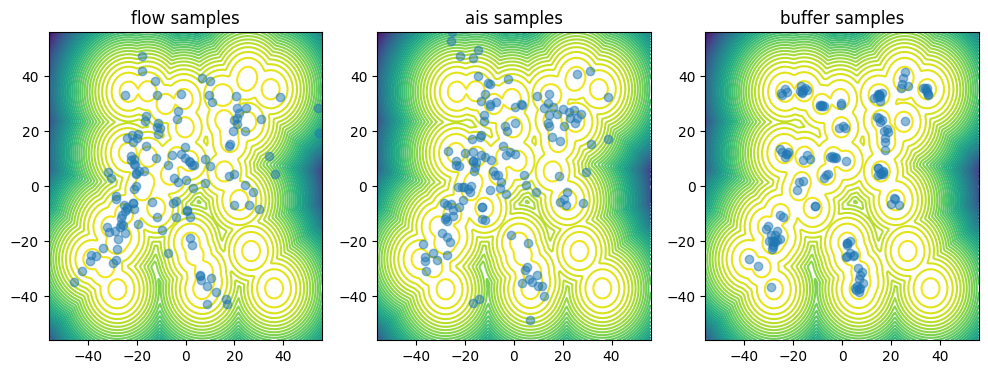

loss: 9.100488914562114, ess base: 0.0941641980169245,ess ais: 0.013266261305308887:  11%|█▏        | 452/4000 [00:25<05:12, 11.36it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.336681913821023, ess base: 0.24461385125474083,ess ais: 0.09415759914927906:  12%|█▏        | 460/4000 [00:26<03:51, 15.32it/s]  

1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.176964617131091, ess base: 0.11418771984465403,ess ais: 0.017793674612572436:  12%|█▏        | 466/4000 [00:26<03:16, 17.95it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.494732309752242, ess base: 0.11685781259816487,ess ais: 0.021429899007276303:  12%|█▏        | 470/4000 [00:26<03:13, 18.26it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.40785855494562, ess base: 0.20162059822895495,ess ais: 0.07947810067305618:  12%|█▏        | 476/4000 [00:26<03:05, 18.97it/s]  

2 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.000535282501767, ess base: 0.22090624855140692,ess ais: 0.10700167323886292:  12%|█▏        | 480/4000 [00:27<03:10, 18.46it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.863213904776838, ess base: 0.21724720783518098,ess ais: 0.06325514431372482:  12%|█▏        | 486/4000 [00:27<03:04, 19.06it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 12.836134877784158, ess base: 0.14175167007688055,ess ais: 0.03595009539452836:  12%|█▏        | 490/4000 [00:27<03:06, 18.86it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.16881305958443, ess base: 0.1385711814748836,ess ais: 0.055919120217198096:  12%|█▏        | 496/4000 [00:27<03:00, 19.38it/s]   

1 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan grad norm in replay step


loss: 8.196871185642749, ess base: 0.10717747773709656,ess ais: 0.0204772300501769:  12%|█▎        | 500/4000 [00:28<03:03, 19.04it/s]  

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.663096664350974, ess base: 0.23687291095325583,ess ais: 0.08664386740342049:  13%|█▎        | 504/4000 [00:28<03:02, 19.16it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.662987233927943, ess base: 0.07940681979516484,ess ais: 0.0078125:  13%|█▎        | 508/4000 [00:28<02:59, 19.49it/s]           

2 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.350430074953357, ess base: 0.2046206214852676,ess ais: 0.07790792622691856:  13%|█▎        | 512/4000 [00:28<02:59, 19.47it/s] 

2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.82224011786311, ess base: 0.11749660709452427,ess ais: 0.030120323087082297:  13%|█▎        | 516/4000 [00:28<02:57, 19.63it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.9844941650320855, ess base: 0.2735941410599298,ess ais: 0.13876873134895035:  13%|█▎        | 520/4000 [00:29<02:57, 19.64it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.200052307193909, ess base: 0.31986735289071905,ess ais: 0.007874015748031496:  13%|█▎        | 524/4000 [00:29<02:57, 19.63it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.153408885115882, ess base: 0.1955262018195542,ess ais: 0.08919010048933249:  13%|█▎        | 530/4000 [00:29<02:56, 19.67it/s]  

2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.327847445306274, ess base: 0.2016108281271249,ess ais: 0.06960457442230253:  13%|█▎        | 532/4000 [00:29<02:56, 19.69it/s] 

2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 10.120960785907707, ess base: 0.21874992963364986,ess ais: 0.07797829482621434:  13%|█▎        | 536/4000 [00:30<03:01, 19.10it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.963305584108758, ess base: 0.26243212142311156,ess ais: 0.1593975462221112:  14%|█▎        | 540/4000 [00:30<03:04, 18.80it/s]  

1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.971904092054974, ess base: 0.2403155557136019,ess ais: 0.07814821175416024:  14%|█▎        | 546/4000 [00:30<03:01, 19.00it/s]  

2 nan/inf samples/log-probs/log-weights encountered at chain init.
4 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.355183514385551, ess base: 0.25869921964681136,ess ais: 0.14282200200845338:  14%|█▍        | 550/4000 [00:30<02:58, 19.32it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.667210787712738, ess base: 0.1802021214528782,ess ais: 0.06239815427215302:  14%|█▍        | 553/4000 [00:30<02:50, 20.19it/s] 

nan loss in replay step
nan grad norm in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.795544987434826, ess base: 0.21839273490701527,ess ais: 0.007874015748031496:  14%|█▍        | 558/4000 [00:31<02:54, 19.77it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 33.70432287490615, ess base: 0.12293891365768982,ess ais: 0.05716984024567637:  14%|█▍        | 563/4000 [00:31<02:51, 20.03it/s]  

nan loss in replay step
2 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 10.484583018776984, ess base: 0.22494012737533792,ess ais: 0.08193117342073376:  14%|█▍        | 569/4000 [00:31<02:59, 19.09it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
2 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 16.616828584721567, ess base: 0.3118457032444516,ess ais: 0.13157645417723385:  14%|█▍        | 574/4000 [00:31<02:52, 19.86it/s]  

3 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: inf, ess base: 0.25184980763902853,ess ais: 0.1384140051279805:  14%|█▍        | 577/4000 [00:32<02:50, 20.08it/s]               

2 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan grad norm in replay step
2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
2 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 8.512771922425692, ess base: 0.11872926890429324,ess ais: 0.02861045141169907:  15%|█▍        | 583/4000 [00:32<02:45, 20.65it/s]

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: inf, ess base: 0.19929090113454123,ess ais: 0.04657520945254314:  15%|█▍        | 586/4000 [00:32<02:44, 20.73it/s]              

nan loss in replay step
4 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step
nan loss in replay step
3 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: inf, ess base: 0.22751058782977296,ess ais: 0.0978112075153043:  15%|█▍        | 592/4000 [00:32<02:40, 21.18it/s]               

nan loss in replay step
nan loss in replay step
2 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step
nan loss in replay step
nan loss in replay step


loss: 8.071142082525833, ess base: 0.2300222746725666,ess ais: 0.03676337980121346:  15%|█▍        | 598/4000 [00:33<02:47, 20.36it/s] 

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step


loss: inf, ess base: 0.19359424802812972,ess ais: 0.05927994898701193:  15%|█▌        | 601/4000 [00:33<02:40, 21.20it/s]              

nan loss in replay step
3 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.927616519788042, ess base: 0.2208033965149814,ess ais: 0.007874015748031496:  15%|█▌        | 607/4000 [00:33<02:41, 21.03it/s]

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: inf, ess base: 0.20626894699577797,ess ais: 0.048357728828943826:  15%|█▌        | 613/4000 [00:33<02:35, 21.75it/s]              

2 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 3.137136418828724e+232, ess base: 0.235867930032464,ess ais: 0.09513348942953552:  15%|█▌        | 616/4000 [00:34<02:42, 20.82it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
nan grad norm in replay step


loss: 9.402009117203562, ess base: 0.2517220727337714,ess ais: 0.12756563229984205:  16%|█▌        | 622/4000 [00:34<02:46, 20.29it/s]      

3 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 65.240369934737, ess base: 0.29439641392546445,ess ais: 0.007936507936507936:  16%|█▌        | 625/4000 [00:34<03:03, 18.39it/s] 

2 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 8.512136306424763, ess base: 0.2194751325270304,ess ais: 0.09878435556230848:  16%|█▌        | 627/4000 [00:34<03:00, 18.71it/s]  

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 7.75195764935545, ess base: 0.221738051975883,ess ais: 0.08457381014970884:  16%|█▌        | 632/4000 [00:34<02:57, 19.02it/s]     

1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.620746065640916, ess base: 0.27630774706836086,ess ais: 0.09789736760843759:  16%|█▌        | 637/4000 [00:35<02:50, 19.75it/s]  

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: inf, ess base: 0.22893506081165657,ess ais: 0.12380089838086197:  16%|█▌        | 643/4000 [00:35<02:46, 20.22it/s]              

nan loss in replay step
nan grad norm in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
4 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.516891343592025, ess base: 0.23715375536104136,ess ais: 0.11798071441127467:  16%|█▌        | 646/4000 [00:35<02:45, 20.26it/s]

nan loss in replay step
5 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.837313875214612, ess base: 0.2923085853523797,ess ais: 0.1685026946794253:  16%|█▋        | 652/4000 [00:35<02:39, 21.04it/s]  

nan loss in replay step
3 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
3 nan/inf samples/log-probs/log-weights encountered at chain init.
5 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.861739963591093, ess base: 0.27509511414157045,ess ais: 0.14454750963297996:  16%|█▋        | 655/4000 [00:35<02:38, 21.10it/s]

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 7.904959493089882, ess base: 0.2181461614204961,ess ais: 0.12916794800624962:  17%|█▋        | 661/4000 [00:36<02:39, 20.93it/s]  

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.924304287570667, ess base: 0.21234870939206962,ess ais: 0.007874015748054816:  17%|█▋        | 667/4000 [00:36<02:37, 21.10it/s]

nan loss in replay step
2 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
5 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.994534710747181, ess base: 0.19229744110158115,ess ais: 0.045049590886558064:  17%|█▋        | 674/4000 [00:36<03:14, 17.12it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
5 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.580545471014922, ess base: 0.28682446611048074,ess ais: 0.16809983062368772:  17%|█▋        | 678/4000 [00:37<03:10, 17.48it/s] 

2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.910770940738939, ess base: 0.26993115621276603,ess ais: 0.14388586846203988:  17%|█▋        | 682/4000 [00:37<03:01, 18.29it/s]

nan loss in replay step
2 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.11019509061984, ess base: 0.17332380185317345,ess ais: 0.04094409354780942:  17%|█▋        | 686/4000 [00:37<02:55, 18.87it/s]      

4 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.
4 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.929536710525752, ess base: 0.29170568274979286,ess ais: 0.17044552584314757:  17%|█▋        | 690/4000 [00:37<02:57, 18.63it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.126117313785507, ess base: 0.23334398060050052,ess ais: 0.0844651829200643:  17%|█▋        | 694/4000 [00:37<02:55, 18.80it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
4 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.833818928521742, ess base: 0.32090080409379323,ess ais: 0.1624475708901982:  17%|█▋        | 699/4000 [00:38<02:50, 19.38it/s]     

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.661145011050165, ess base: 0.23683419944577772,ess ais: 0.10274879198289563:  18%|█▊        | 701/4000 [00:38<02:50, 19.34it/s] 

2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.992633161922612, ess base: 0.29946747273764757,ess ais: 0.0078125:  18%|█▊        | 705/4000 [00:38<02:55, 18.75it/s]          

3 nan/inf samples/log-probs/log-weights encountered at chain init.
nan grad norm in replay step


loss: 8.568912068769553, ess base: 0.27521353328249615,ess ais: 0.10755446428126327:  18%|█▊        | 711/4000 [00:38<03:04, 17.87it/s] 

5 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.5890599797284155, ess base: 0.27941660673905266,ess ais: 0.00781250027769404:  18%|█▊        | 715/4000 [00:39<03:18, 16.57it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.671807624703957, ess base: 0.25566997054890145,ess ais: 0.08879878160115168:  18%|█▊        | 719/4000 [00:39<03:06, 17.61it/s]      

1 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.29028755809359, ess base: 0.21375786275922945,ess ais: 0.11693093397609591:  18%|█▊        | 723/4000 [00:39<02:59, 18.23it/s] 

2 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 62.282014518716736, ess base: 0.27139658405784034,ess ais: 0.09129925028568381:  18%|█▊        | 727/4000 [00:39<03:49, 14.24it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.157285274823334, ess base: 0.29497223734039885,ess ais: 0.13432128798118434:  18%|█▊        | 729/4000 [00:40<03:46, 14.45it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: inf, ess base: 0.1619578171049927,ess ais: 0.04678822436237456:  18%|█▊        | 733/4000 [00:40<03:41, 14.78it/s]               

nan loss in replay step
3 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
4 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: nan, ess base: 0.26465929896213014,ess ais: 0.14278973880121798:  18%|█▊        | 739/4000 [00:40<03:02, 17.90it/s]              

nan loss in replay step
4 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 9.393472888651038, ess base: 0.24905594133505832,ess ais: 0.12083966475581556:  19%|█▊        | 745/4000 [00:41<03:23, 15.98it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.980162575296074, ess base: 0.1544445523094763,ess ais: 0.019520698829791575:  19%|█▊        | 749/4000 [00:41<03:05, 17.53it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.
4 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 10.128258461119337, ess base: 0.2221639339195135,ess ais: 0.11310256170035564:  19%|█▉        | 753/4000 [00:41<03:10, 17.07it/s]

4 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 9.157610700485836, ess base: 0.24772377243428845,ess ais: 0.1163478894157674:  19%|█▉        | 757/4000 [00:41<03:26, 15.72it/s]  

2 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.350243178353965, ess base: 0.13352365996927282,ess ais: 0.022953212971718207:  19%|█▉        | 761/4000 [00:41<03:08, 17.16it/s]

3 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 74.89417063083218, ess base: 0.251171348330592,ess ais: 0.11070665013644655:  19%|█▉        | 765/4000 [00:42<03:01, 17.85it/s]   

3 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.32790103326606, ess base: 0.21401619169740072,ess ais: 0.08962376341730095:  19%|█▉        | 769/4000 [00:42<02:58, 18.14it/s]

4 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
4 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 101.48741006775619, ess base: 0.30646985954445877,ess ais: 0.16329656483742197:  19%|█▉        | 773/4000 [00:42<02:58, 18.12it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 9.02548230839634, ess base: 0.280654702564421,ess ais: 0.14329979916227023:  19%|█▉        | 777/4000 [00:42<02:54, 18.52it/s]    

2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.684725518010605, ess base: 0.24112145174440539,ess ais: 0.10322722050471904:  20%|█▉        | 781/4000 [00:43<02:54, 18.48it/s]

5 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.033429523005667, ess base: 0.29302685583959676,ess ais: 0.007936507936507936:  20%|█▉        | 785/4000 [00:43<03:14, 16.49it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.871581716479215, ess base: 0.2918472657912818,ess ais: 0.008717393663796178:  20%|█▉        | 791/4000 [00:43<02:55, 18.33it/s] 

2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.717608187049594, ess base: 0.2521067635287482,ess ais: 0.07803613341315964:  20%|█▉        | 793/4000 [00:43<02:54, 18.41it/s]   

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.
4 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.8130123994641085, ess base: 0.23282559874248815,ess ais: 0.10404830504004722:  20%|█▉        | 799/4000 [00:44<02:52, 18.52it/s]   

2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
6 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.626687165206558, ess base: 0.30436922329142957,ess ais: 0.1434912069369773:  20%|██        | 803/4000 [00:44<02:48, 19.01it/s]  

1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.620002572216239, ess base: 0.319464022073221,ess ais: 0.18162382137079727:  20%|██        | 807/4000 [00:44<02:48, 18.98it/s]   

7 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.50675799370927, ess base: 0.21146066201975833,ess ais: 0.07098728845963824:  20%|██        | 813/4000 [00:44<02:54, 18.30it/s] 

4 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.632946776377699, ess base: 0.29009122847900165,ess ais: 0.08262227858001761:  20%|██        | 819/4000 [00:45<02:58, 17.78it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 2.1129482649355237e+75, ess base: 0.2456537487356198,ess ais: 0.008064516129032258:  21%|██        | 823/4000 [00:45<02:55, 18.10it/s]

4 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
4 nan/inf samples/log-probs/log-weights encountered at chain init.
4 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 377309982946.6633, ess base: 0.24197758859290264,ess ais: 0.133589701530796:  21%|██        | 829/4000 [00:45<02:46, 19.01it/s]       

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.443298070932281, ess base: 0.28022534642562985,ess ais: 0.1277761103006299:  21%|██        | 831/4000 [00:45<02:46, 19.08it/s]  

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.229234772258014, ess base: 0.2753303951832848,ess ais: 0.1323241217788022:  21%|██        | 835/4000 [00:46<02:44, 19.20it/s]  

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.337458141605696, ess base: 0.24660304723533943,ess ais: 0.11169169365018997:  21%|██        | 839/4000 [00:46<03:05, 17.00it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.541608951111042, ess base: 0.2619866529187776,ess ais: 0.16257260168364354:  21%|██        | 843/4000 [00:46<03:17, 15.97it/s]  

2 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.212600362892562, ess base: 0.30416117030908985,ess ais: 0.14624736451043735:  21%|██        | 847/4000 [00:46<03:04, 17.08it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 10.120252010353571, ess base: 0.31675760136116343,ess ais: 0.007874637771071547:  21%|██▏       | 851/4000 [00:47<03:04, 17.08it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.948666284863881, ess base: 0.2871027802160014,ess ais: 0.008:  21%|██▏       | 859/4000 [00:47<02:55, 17.85it/s]                 

1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.129559628447314, ess base: 0.31139284551322133,ess ais: 0.007874015748031496:  22%|██▏       | 863/4000 [00:47<02:49, 18.51it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.054965636240023, ess base: 0.28396353659237333,ess ais: 0.19828216244961666:  22%|██▏       | 873/4000 [00:48<02:41, 19.34it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 81596035148.06264, ess base: 0.1990546723340122,ess ais: 0.0656284367970925:  22%|██▏       | 875/4000 [00:48<02:41, 19.31it/s]  

2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.31121720735234, ess base: 0.2518932016721095,ess ais: 0.12684402116857124:  22%|██▏       | 879/4000 [00:48<02:49, 18.46it/s]  

2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 9.245723349033923, ess base: 0.26126552199181013,ess ais: 0.11562864208491087:  22%|██▏       | 883/4000 [00:48<03:11, 16.28it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.867129354174887, ess base: 0.27839042850460965,ess ais: 0.13102303185409625:  22%|██▏       | 887/4000 [00:49<03:05, 16.82it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.685873059316872, ess base: 0.2551257547967591,ess ais: 0.14204986761742172:  22%|██▏       | 887/4000 [00:49<03:05, 16.82it/s] 

2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


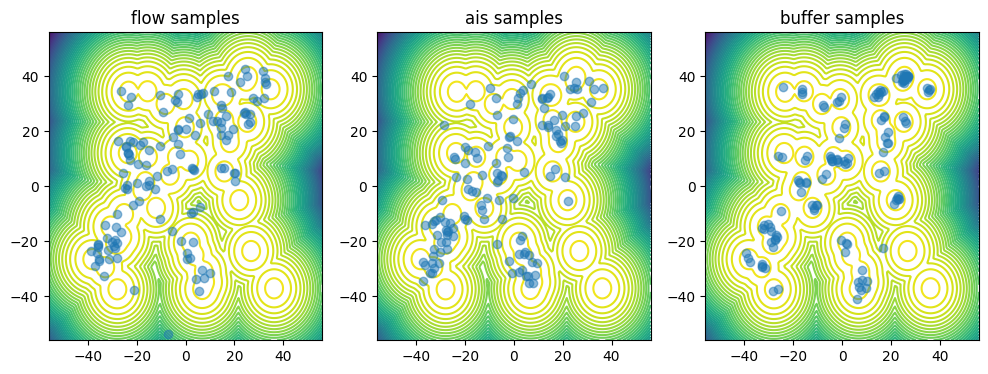

loss: 8.153965288346704, ess base: 0.28353831785131234,ess ais: 0.1643208174025063:  22%|██▏       | 893/4000 [00:50<06:35,  7.85it/s]  

2 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.
4 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.520153476805916, ess base: 0.26164971224615874,ess ais: 0.11912885713054515:  22%|██▏       | 897/4000 [00:50<04:34, 11.29it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.547270877009112, ess base: 0.27436786094558174,ess ais: 0.14660843152961764:  23%|██▎       | 901/4000 [00:50<03:37, 14.23it/s] 

2 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 9.072397671410705, ess base: 0.2554944421848577,ess ais: 0.007874015748031496:  23%|██▎       | 905/4000 [00:50<03:10, 16.25it/s]    

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 14.805986251722548, ess base: 0.3106894972654033,ess ais: 0.1446576845091579:  23%|██▎       | 909/4000 [00:51<02:56, 17.52it/s]  

3 nan/inf samples/log-probs/log-weights encountered at chain init.
4 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 26.707795520021776, ess base: 0.27240655499698224,ess ais: 0.16516736939266635:  23%|██▎       | 913/4000 [00:51<02:51, 18.04it/s]

3 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.453329099936587, ess base: 0.305194228312434,ess ais: 0.18503534377922132:  23%|██▎       | 927/4000 [00:52<02:50, 18.04it/s]   

1 nan/inf samples/log-probs/log-weights encountered at chain init.
5 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.702601273100067, ess base: 0.24920714753779552,ess ais: 0.1019303478688434:  23%|██▎       | 937/4000 [00:52<02:41, 18.93it/s] 

3 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.816546747680635, ess base: 0.3669898150178029,ess ais: 0.2114844377955897:  24%|██▎       | 945/4000 [00:53<02:37, 19.40it/s]  

2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.877008833130916, ess base: 0.24458051349964513,ess ais: 0.07938984558174292:  24%|██▍       | 951/4000 [00:53<02:41, 18.92it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.181556713980365, ess base: 0.27451570984647056,ess ais: 0.10753447699628486:  24%|██▍       | 955/4000 [00:53<02:40, 18.98it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.521018427277937, ess base: 0.24354356219058335,ess ais: 0.12380399467857457:  24%|██▍       | 959/4000 [00:53<02:45, 18.36it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.5623162539531545, ess base: 0.29885453127382805,ess ais: 0.1738680711137631:  24%|██▍       | 961/4000 [00:54<03:06, 16.26it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 9.219266649025684, ess base: 0.26773614184462896,ess ais: 0.08161291464101675:  24%|██▍       | 965/4000 [00:54<02:53, 17.45it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.8452368000468065, ess base: 0.207994701077756,ess ais: 0.06998582094509921:  24%|██▍       | 971/4000 [00:54<02:44, 18.39it/s]  

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.194033812303863, ess base: 0.2839842830177889,ess ais: 0.1578598514021218:  24%|██▍       | 975/4000 [00:54<02:40, 18.83it/s]  

2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 11.943200636355224, ess base: 0.3278923029794755,ess ais: 0.18418836927663232:  24%|██▍       | 979/4000 [00:54<02:36, 19.29it/s] 

3 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.025042734680738, ess base: 0.27237712220775007,ess ais: 0.007874015748031496:  25%|██▍       | 981/4000 [00:55<02:36, 19.25it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.63035268851767, ess base: 0.3034001726283842,ess ais: 0.18250804201310228:  25%|██▍       | 987/4000 [00:55<02:46, 18.06it/s]   

2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 244941.1903751326, ess base: 0.325997998938832,ess ais: 0.00781275017535092:  25%|██▍       | 991/4000 [00:55<02:39, 18.81it/s]   

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.658281052735612, ess base: 0.3664705522786309,ess ais: 0.22166181318828002:  25%|██▍       | 997/4000 [00:55<02:38, 18.96it/s]  

1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.126744028234944, ess base: 0.3329691030092644,ess ais: 0.007975240785369132:  25%|██▌       | 1002/4000 [00:56<02:35, 19.31it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 12.142993601939345, ess base: 0.2739628927243604,ess ais: 0.14916244332852108:  25%|██▌       | 1009/4000 [00:56<02:31, 19.69it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 13.03263092752853, ess base: 0.20599206594743266,ess ais: 0.0713144958558881:  25%|██▌       | 1019/4000 [00:57<02:36, 19.07it/s] 

2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.463301018293574, ess base: 0.31108859886815887,ess ais: 0.1665993343404534:  26%|██▌       | 1023/4000 [00:57<02:41, 18.41it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.93051505656854, ess base: 0.32968645815696923,ess ais: 0.17035080998538643:  26%|██▌       | 1029/4000 [00:57<02:48, 17.59it/s] 

3 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.53969740234343, ess base: 0.2680566955881364,ess ais: 0.10980682872301935:  26%|██▌       | 1033/4000 [00:57<02:48, 17.65it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 9.634269328908228, ess base: 0.2607807886436542,ess ais: 0.11458697957479212:  26%|██▌       | 1039/4000 [00:58<02:46, 17.73it/s]  

1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 9.384738468823105, ess base: 0.25106637576903407,ess ais: 0.11255993009991454:  26%|██▌       | 1047/4000 [00:58<02:39, 18.50it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.
4 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.918564443399026, ess base: 0.32645308344021834,ess ais: 0.15254170871969305:  26%|██▌       | 1049/4000 [00:58<02:38, 18.66it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 368.54380595834306, ess base: 0.3263210016571816,ess ais: 0.13556274328123824:  26%|██▋       | 1056/4000 [00:59<02:30, 19.51it/s] 

2 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.694368263136694, ess base: 0.30207347556674136,ess ais: 0.14443732067541604:  27%|██▋       | 1063/4000 [00:59<02:28, 19.74it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.90885941811721, ess base: 0.2249361587693971,ess ais: 0.055783452424549705:  27%|██▋       | 1069/4000 [00:59<02:28, 19.80it/s] 

2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.48001585395182, ess base: 0.3067042261723315,ess ais: 0.1272146087851806:  27%|██▋       | 1075/4000 [01:00<02:45, 17.63it/s]   

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan grad norm in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.878571040097505, ess base: 0.28986225596075127,ess ais: 0.06285198942719944:  27%|██▋       | 1084/4000 [01:00<02:30, 19.32it/s]      

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan grad norm in replay step


loss: 8.376425752230215, ess base: 0.3266387777721073,ess ais: 0.15061443187269455:  27%|██▋       | 1089/4000 [01:00<02:28, 19.66it/s] 

2 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.352211415271025, ess base: 0.29984264256924725,ess ais: 0.16449182945627858:  27%|██▋       | 1096/4000 [01:01<02:26, 19.84it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.
4 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.801924241906968, ess base: 0.31549939761829204,ess ais: 0.15091583771312264:  28%|██▊       | 1100/4000 [01:01<02:46, 17.47it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.48237246798709, ess base: 0.3024032779463308,ess ais: 0.1405716062439435:  28%|██▊       | 1108/4000 [01:01<02:35, 18.58it/s]       

3 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.581754620380998, ess base: 0.30831945117558596,ess ais: 0.0078125:  28%|██▊       | 1114/4000 [01:02<02:32, 18.93it/s]          

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan grad norm in replay step


loss: 7.969888889867893, ess base: 0.2916082630933227,ess ais: 0.15380212791197637:  28%|██▊       | 1120/4000 [01:02<02:28, 19.43it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.418652112404946, ess base: 0.3684240202151214,ess ais: 0.19952351050012876:  28%|██▊       | 1122/4000 [01:02<02:29, 19.27it/s] 

2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.625814721286424, ess base: 0.34885605554258675,ess ais: 0.18526201674102022:  28%|██▊       | 1134/4000 [01:03<02:42, 17.68it/s] 

3 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.061566169028398, ess base: 0.3679107170613602,ess ais: 0.0078125:  29%|██▊       | 1144/4000 [01:03<02:30, 18.97it/s]            

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.533185087115081, ess base: 0.33089538385312284,ess ais: 0.15841213714359487:  29%|██▊       | 1148/4000 [01:04<02:42, 17.59it/s]

nan loss in replay step


loss: 7.688833474238313, ess base: 0.29278071397678923,ess ais: 0.1068505076723885:  29%|██▉       | 1160/4000 [01:04<02:32, 18.65it/s]  

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.239320273134208, ess base: 0.30100811297280416,ess ais: 0.11146307379337221:  29%|██▉       | 1166/4000 [01:05<02:30, 18.83it/s] 

2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 9.389525928446142, ess base: 0.3118667658625728,ess ais: 0.1277521701572848:  29%|██▉       | 1174/4000 [01:05<03:26, 13.70it/s]  

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.657145738410906, ess base: 0.3938750075548865,ess ais: 0.24014689595831484:  30%|██▉       | 1182/4000 [01:06<03:03, 15.32it/s]  

2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 3272.489589971209, ess base: 0.3417469639563056,ess ais: 0.1628938118900979:  30%|██▉       | 1188/4000 [01:06<03:37, 12.93it/s]  

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 9.189391570246022, ess base: 0.30064078189628574,ess ais: 0.14288377239944822:  30%|██▉       | 1194/4000 [01:07<02:54, 16.10it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.523398996540664, ess base: 0.36513037796908876,ess ais: 0.14671782368343972:  30%|███       | 1202/4000 [01:07<02:54, 16.06it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.74336295590101, ess base: 0.29306891894703974,ess ais: 0.1401543319542079:  30%|███       | 1206/4000 [01:07<02:40, 17.44it/s]  

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 9.395022181413472, ess base: 0.27854631372931143,ess ais: 0.11114503379652907:  31%|███       | 1226/4000 [01:08<02:32, 18.15it/s] 

2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.39372655269581, ess base: 0.28998653016444115,ess ais: 0.15073181678425832:  31%|███       | 1228/4000 [01:09<02:30, 18.38it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.399243721765684, ess base: 0.3556669985953205,ess ais: 0.15135259543044421:  31%|███       | 1241/4000 [01:09<02:22, 19.38it/s]  

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.840124913783301, ess base: 0.32970000452897297,ess ais: 0.00954781132489368:  31%|███       | 1243/4000 [01:09<02:39, 17.31it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.663315372939382, ess base: 0.3098795846232966,ess ais: 0.14725387731510683:  31%|███▏      | 1251/4000 [01:10<02:25, 18.85it/s]  

2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 15.476315534348302, ess base: 0.32695381437638293,ess ais: 0.18644128486237943:  32%|███▏      | 1270/4000 [01:11<02:22, 19.11it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.92339047199174, ess base: 0.4368672298074257,ess ais: 0.27106670385892906:  32%|███▏      | 1281/4000 [01:11<02:25, 18.68it/s]   

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.809512687475862, ess base: 0.2896330984492595,ess ais: 0.06731470416332536:  32%|███▏      | 1290/4000 [01:12<02:18, 19.57it/s]  

2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.020237670971897, ess base: 0.35300641516492154,ess ais: 0.17105768858625728:  33%|███▎      | 1311/4000 [01:13<02:16, 19.68it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.637629583222964, ess base: 0.29593440341921545,ess ais: 0.10681367705820236:  33%|███▎      | 1320/4000 [01:13<02:15, 19.73it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 9.762047805261512, ess base: 0.3282382861041508,ess ais: 0.21408662260829794:  33%|███▎      | 1322/4000 [01:14<02:33, 17.47it/s] 

2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.84689711361569, ess base: 0.2591481511308278,ess ais: 0.16545671714396282:  33%|███▎      | 1330/4000 [01:14<02:19, 19.12it/s]   

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.98945965507614, ess base: 0.3436061353534528,ess ais: 0.19203755930504307:  33%|███▎      | 1333/4000 [01:14<02:17, 19.36it/s]  

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


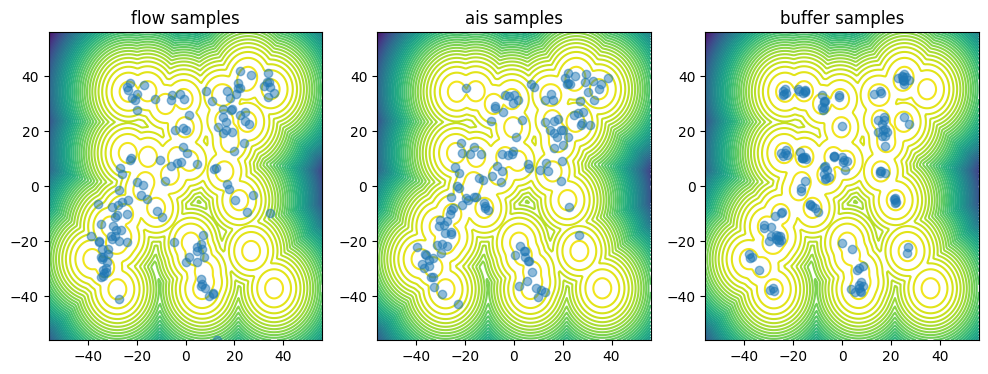

loss: 8.233138301910914, ess base: 0.30125383473068096,ess ais: 0.16240576511568905:  33%|███▎      | 1339/4000 [01:15<04:45,  9.33it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 9.383490324591527, ess base: 0.3521618823896211,ess ais: 0.17785084740325188:  34%|███▎      | 1343/4000 [01:15<03:31, 12.59it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.371584163587759e+22, ess base: 0.2901313302109934,ess ais: 0.0078125:  34%|███▎      | 1349/4000 [01:16<02:42, 16.33it/s]        

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.98573490917544, ess base: 0.3894716661874407,ess ais: 0.21421351996737345:  34%|███▍      | 1355/4000 [01:16<02:24, 18.29it/s]  

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.715313002287612, ess base: 0.32096418579497643,ess ais: 0.16861699682952042:  34%|███▍      | 1357/4000 [01:16<02:40, 16.51it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.292945955470758, ess base: 0.3510320951546394,ess ais: 0.16714563083481493:  35%|███▍      | 1384/4000 [01:18<02:15, 19.26it/s]  

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 16.018187027102577, ess base: 0.32581929273951604,ess ais: 0.13866699492053727:  35%|███▍      | 1390/4000 [01:18<02:13, 19.50it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 10.98918277535287, ess base: 0.39933585456172704,ess ais: 0.20861966579560262:  35%|███▌      | 1408/4000 [01:19<02:15, 19.10it/s]    

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.7145335509710655, ess base: 0.3179251431886645,ess ais: 0.15773083654758704:  35%|███▌      | 1414/4000 [01:19<02:21, 18.22it/s]  

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.862797183638545, ess base: 0.35712535524616,ess ais: 0.2371004973818128:  36%|███▋      | 1456/4000 [01:22<02:45, 15.36it/s]       

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 11.19297579850415, ess base: 0.22972990173202487,ess ais: 0.0078125:  37%|███▋      | 1466/4000 [01:23<03:24, 12.37it/s]          

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 13.401730463469757, ess base: 0.2697573248297255,ess ais: 0.1464051303930674:  37%|███▋      | 1470/4000 [01:23<03:31, 11.95it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.378138772603899, ess base: 0.3418232035629438,ess ais: 0.19112098286339865:  37%|███▋      | 1474/4000 [01:23<03:07, 13.50it/s]   

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.951043666347203, ess base: 0.2750218895246696,ess ais: 0.16039455683312254:  37%|███▋      | 1478/4000 [01:24<02:45, 15.20it/s]  

2 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 25.463010968050952, ess base: 0.26100872821029697,ess ais: 0.12284933368655153:  37%|███▋      | 1482/4000 [01:24<02:40, 15.69it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: inf, ess base: 0.32464866809029913,ess ais: 0.14495080476595995:  37%|███▋      | 1486/4000 [01:24<02:31, 16.57it/s]               

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 8.190867733095576, ess base: 0.26961047384670006,ess ais: 0.0636872845500899:  37%|███▋      | 1490/4000 [01:24<02:22, 17.67it/s]  

nan loss in replay step
nan grad norm in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 12.22119031114587, ess base: 0.07212963118709685,ess ais: 0.009615460363239786:  37%|███▋      | 1498/4000 [01:25<02:30, 16.60it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.574180028036686, ess base: 0.24314239778211447,ess ais: 0.1476201996816799:  38%|███▊      | 1504/4000 [01:25<02:34, 16.12it/s]  

1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.05159089513357, ess base: 0.391079211647283,ess ais: 0.23257947553208116:  38%|███▊      | 1510/4000 [01:25<02:35, 15.99it/s]   

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.915200538512412, ess base: 0.3261741228708356,ess ais: 0.0078125:  38%|███▊      | 1518/4000 [01:26<02:23, 17.25it/s]            

nan loss in replay step
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.2569025900393, ess base: 0.3142526782293095,ess ais: 0.18195528408028677:  38%|███▊      | 1522/4000 [01:26<02:18, 17.93it/s]   

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: inf, ess base: 0.37237705372710267,ess ais: 0.19548178770967634:  38%|███▊      | 1524/4000 [01:26<02:31, 16.36it/s]           

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step


loss: 9.10146899480888, ess base: 0.13042814958972662,ess ais: 0.017896615318383963:  38%|███▊      | 1530/4000 [01:27<02:22, 17.32it/s] 

nan loss in replay step
nan loss in replay step
3 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.932563456412253, ess base: 0.26689374026335244,ess ais: 0.09082748423830306:  38%|███▊      | 1535/4000 [01:27<02:08, 19.19it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
5 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
3 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 7.813735518291118, ess base: 0.3259787825506844,ess ais: 0.18666607195996565:  38%|███▊      | 1539/4000 [01:27<02:11, 18.76it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 7.50405779210519, ess base: 0.3030171472988631,ess ais: 0.14765486119778748:  39%|███▊      | 1545/4000 [01:27<02:18, 17.78it/s]       

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.719571633595895, ess base: 0.28705730215651243,ess ais: 0.15109700510025795:  39%|███▊      | 1549/4000 [01:28<02:26, 16.68it/s]

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step


loss: 9.530100358106404, ess base: 0.303110270349357,ess ais: 0.12312698193950639:  39%|███▉      | 1555/4000 [01:28<02:09, 18.83it/s]  

2 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step


loss: 7.691760123427919, ess base: 0.4044370452604487,ess ais: 0.24234240720406755:  39%|███▉      | 1559/4000 [01:28<02:06, 19.22it/s] 

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 8.352336695455326, ess base: 0.30748893928158644,ess ais: 0.15629263491784495:  39%|███▉      | 1565/4000 [01:28<02:02, 19.87it/s]

nan grad norm in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan grad norm in replay step


loss: 7.596912584199984, ess base: 0.33864897062124094,ess ais: 0.007874015748031496:  39%|███▉      | 1570/4000 [01:29<02:01, 19.99it/s]

nan loss in replay step
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.233305614659974, ess base: 0.3895900710341861,ess ais: 0.19567166865550106:  39%|███▉      | 1574/4000 [01:29<02:03, 19.64it/s]  

2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.296273193020365, ess base: 0.4267614689873611,ess ais: 0.23518589381044955:  40%|███▉      | 1580/4000 [01:29<02:12, 18.30it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.493559652253015, ess base: 0.39586717864534116,ess ais: 0.20000174215082442:  40%|███▉      | 1590/4000 [01:30<02:06, 19.00it/s]  

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 198533767012.14844, ess base: 0.31655754420373294,ess ais: 0.1387908874504317:  40%|███▉      | 1594/4000 [01:30<02:05, 19.12it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.19532331165798, ess base: 0.26539889726850047,ess ais: 0.0738193082452679:  40%|███▉      | 1598/4000 [01:30<02:05, 19.11it/s]   

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.055395251627921, ess base: 0.359193088756825,ess ais: 0.19342647879937486:  40%|████      | 1610/4000 [01:31<02:04, 19.23it/s]   

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.983341321809819, ess base: 0.3605679222454527,ess ais: 0.20499266476470987:  40%|████      | 1614/4000 [01:31<02:03, 19.31it/s] 

2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.050021461351156, ess base: 0.3089934576234742,ess ais: 0.0078125:  40%|████      | 1620/4000 [01:31<02:03, 19.33it/s]           

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan grad norm in replay step


loss: 7.967162961176905, ess base: 0.3325829960315126,ess ais: 0.14643308253482976:  41%|████      | 1624/4000 [01:32<02:04, 19.03it/s]  

nan grad norm in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 12.920858542613066, ess base: 0.28561478795875994,ess ais: 0.13336480850821067:  41%|████      | 1632/4000 [01:32<02:10, 18.16it/s] 

2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan grad norm in replay step


loss: 9.370294666815893, ess base: 0.28938185807728484,ess ais: 0.007874015748031496:  41%|████      | 1636/4000 [01:32<02:07, 18.57it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 1.1339514385698577e+43, ess base: 0.29051608632264897,ess ais: 0.09363159156226851:  41%|████      | 1640/4000 [01:32<02:05, 18.85it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 6.137799403403012e+16, ess base: 0.3103699960324981,ess ais: 0.1443062321390953:  41%|████      | 1644/4000 [01:33<02:20, 16.79it/s]   

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.116196185612669e+52, ess base: 0.12228410851564976,ess ais: 0.0078125:  41%|████▏     | 1650/4000 [01:33<02:12, 17.76it/s]          

nan grad norm in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 10.348625736987001, ess base: 0.16790182222751887,ess ais: 0.0521829020480619:  41%|████▏     | 1654/4000 [01:33<02:14, 17.50it/s]  

2 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 9.59129660930496, ess base: 0.25691299686936997,ess ais: 0.07458919593277796:  42%|████▏     | 1660/4000 [01:34<02:08, 18.24it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 58.382391255525775, ess base: 0.2935089246219242,ess ais: 0.18394896751165157:  42%|████▏     | 1666/4000 [01:34<02:06, 18.50it/s]

4 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 3576652699.587607, ess base: 0.22862135317317855,ess ais: 0.12109436896986354:  42%|████▏     | 1670/4000 [01:34<02:03, 18.93it/s]     

5 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan grad norm in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 12561.068246124089, ess base: 0.0639233440856689,ess ais: 0.03665342001497795:  42%|████▏     | 1674/4000 [01:34<02:03, 18.89it/s] 

2 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 16.205085616199725, ess base: 0.07883816090337999,ess ais: 0.02681550506406805:  42%|████▏     | 1676/4000 [01:35<02:09, 17.98it/s] 

8 nan/inf samples/log-probs/log-weights encountered at chain init.
8 nan/inf samples/log-probs/log-weights encountered at chain init.
7 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 3050.4699584205364, ess base: 0.13576886792165352,ess ais: 0.059249426577718645:  42%|████▏     | 1678/4000 [01:35<02:33, 15.14it/s]

7 nan/inf samples/log-probs/log-weights encountered at chain init.
6 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 1688.4707342680863, ess base: 0.19528818823131822,ess ais: 0.06721996888344631:  42%|████▏     | 1682/4000 [01:35<02:53, 13.37it/s] 

4 nan/inf samples/log-probs/log-weights encountered at chain init.
5 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
7 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 27.951974119806327, ess base: 0.13534765375553465,ess ais: 0.07545364763703813:  42%|████▏     | 1686/4000 [01:35<02:59, 12.90it/s] 

5 nan/inf samples/log-probs/log-weights encountered at chain init.
9 nan/inf samples/log-probs/log-weights encountered at chain init.
9 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 10.43691779844843, ess base: 0.18831952419630218,ess ais: 0.07486284260051879:  42%|████▏     | 1688/4000 [01:35<02:58, 12.98it/s] 

9 nan/inf samples/log-probs/log-weights encountered at chain init.
7 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 13.797734241572822, ess base: 0.11799101480270524,ess ais: 0.03557608029863144:  42%|████▏     | 1692/4000 [01:36<02:54, 13.20it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
5 nan/inf samples/log-probs/log-weights encountered at chain init.
4 nan/inf samples/log-probs/log-weights encountered at chain init.
7 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 28.309431843104647, ess base: 0.1401188783743384,ess ais: 0.07578291949055894:  42%|████▏     | 1694/4000 [01:36<02:57, 13.03it/s] 

7 nan/inf samples/log-probs/log-weights encountered at chain init.
8 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 28.441257115703642, ess base: 0.18599241119774326,ess ais: 0.008083874566458291:  42%|████▏     | 1698/4000 [01:36<02:57, 12.98it/s]

11 nan/inf samples/log-probs/log-weights encountered at chain init.
4 nan/inf samples/log-probs/log-weights encountered at chain init.
5 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 9.18188726130145, ess base: 0.1961243262056472,ess ais: 0.10540935706710555:  42%|████▎     | 1700/4000 [01:36<02:52, 13.37it/s]    

4 nan/inf samples/log-probs/log-weights encountered at chain init.
5 nan/inf samples/log-probs/log-weights encountered at chain init.
9 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 9.252751252191842, ess base: 0.17960386832448022,ess ais: 0.08433491144077583:  43%|████▎     | 1704/4000 [01:37<02:51, 13.36it/s]

4 nan/inf samples/log-probs/log-weights encountered at chain init.
8 nan/inf samples/log-probs/log-weights encountered at chain init.
4 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 15.51618501750551, ess base: 0.09492436886702002,ess ais: 0.013553788870459273:  43%|████▎     | 1708/4000 [01:37<02:34, 14.86it/s]

6 nan/inf samples/log-probs/log-weights encountered at chain init.
5 nan/inf samples/log-probs/log-weights encountered at chain init.
nan grad norm in replay step
5 nan/inf samples/log-probs/log-weights encountered at chain init.
4 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 9.114610283821882, ess base: 0.19464617060617975,ess ais: 0.07581304865651503:  43%|████▎     | 1713/4000 [01:37<02:12, 17.22it/s] 

6 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step
6 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
4 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.050658337204451, ess base: 0.2040905071156599,ess ais: 0.07820300359213368:  43%|████▎     | 1717/4000 [01:37<02:14, 16.98it/s]  

2 nan/inf samples/log-probs/log-weights encountered at chain init.
5 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.723508733901799, ess base: 0.1887389545072976,ess ais: 0.03469357379107635:  43%|████▎     | 1721/4000 [01:38<02:09, 17.59it/s]   

2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 28506.63159469096, ess base: 0.24566417983081903,ess ais: 0.1394042319223293:  43%|████▎     | 1725/4000 [01:38<02:05, 18.12it/s]   

2 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 14.804430894907268, ess base: 0.10795143748766843,ess ais: 0.030432769839085848:  43%|████▎     | 1729/4000 [01:38<02:02, 18.51it/s]

5 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
5 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 22.81536558391629, ess base: 0.1792327703327338,ess ais: 0.0851728989512717:  43%|████▎     | 1733/4000 [01:38<01:59, 18.99it/s]    

2 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 12.399743953429256, ess base: 0.21263097243377543,ess ais: 0.14011213044857276:  43%|████▎     | 1737/4000 [01:38<01:57, 19.26it/s]

4 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 566467.9736970417, ess base: 0.15758278645589985,ess ais: 0.007936507936507936:  44%|████▎     | 1741/4000 [01:39<02:06, 17.86it/s]

7 nan/inf samples/log-probs/log-weights encountered at chain init.
5 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 28.711107433350385, ess base: 0.15750034694175308,ess ais: 0.042071448063961174:  44%|████▎     | 1745/4000 [01:39<02:00, 18.64it/s]

3 nan/inf samples/log-probs/log-weights encountered at chain init.
4 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.857579488892096, ess base: 0.16936913542230914,ess ais: 0.14850457356726626:  44%|████▎     | 1749/4000 [01:39<01:58, 18.98it/s]  

5 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.611121857922338, ess base: 0.2299405879806166,ess ais: 0.13312664222912737:  44%|████▍     | 1753/4000 [01:39<02:09, 17.35it/s] 

2 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
4 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.285619116740088, ess base: 0.27623623358414046,ess ais: 0.12836304763977766:  44%|████▍     | 1757/4000 [01:40<02:03, 18.22it/s] 

3 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
4 nan/inf samples/log-probs/log-weights encountered at chain init.
4 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 29.2259015368519, ess base: 0.16042674050693184,ess ais: 0.033020912716641745:  44%|████▍     | 1761/4000 [01:40<01:59, 18.74it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.03427522145097, ess base: 0.2709022826110806,ess ais: 0.011387502413920536:  44%|████▍     | 1765/4000 [01:40<01:58, 18.90it/s]  

3 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.500634961554429, ess base: 0.1740372394938617,ess ais: 0.03553707516124219:  44%|████▍     | 1769/4000 [01:40<01:57, 18.92it/s] 

6 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.86668672717282, ess base: 0.30124429784677953,ess ais: 0.17485288072251792:  44%|████▍     | 1773/4000 [01:40<02:05, 17.71it/s] 

4 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 9.499267967030077, ess base: 0.23662192047905142,ess ais: 0.09204077684888191:  44%|████▍     | 1777/4000 [01:41<02:01, 18.30it/s] 

2 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
4 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weight

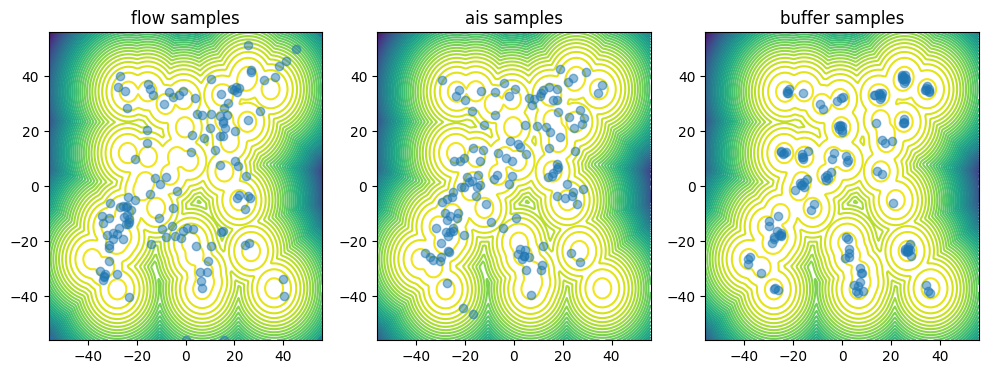

loss: 15.601660610803943, ess base: 0.23259545678718901,ess ais: 0.09877592319238845:  45%|████▍     | 1781/4000 [01:42<04:55,  7.50it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.830853007099995, ess base: 0.2172488741669717,ess ais: 0.11301815694183233:  45%|████▍     | 1785/4000 [01:42<03:36, 10.25it/s]  

3 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 611.1314827755803, ess base: 0.17761330069564932,ess ais: 0.033152968548453454:  45%|████▍     | 1789/4000 [01:42<02:50, 12.97it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.337245231101768, ess base: 0.23238516335747764,ess ais: 0.11844611391690144:  45%|████▍     | 1793/4000 [01:42<02:26, 15.09it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 17.7098482149006, ess base: 0.16666000551189716,ess ais: 0.04770229256587835:  45%|████▍     | 1795/4000 [01:43<02:17, 16.06it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 15920.771947026002, ess base: 0.19014681242522521,ess ais: 0.0078125:  45%|████▌     | 1800/4000 [01:43<02:15, 16.30it/s]             

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 10.623068401875983, ess base: 0.16735080661037233,ess ais: 0.07016777828391912:  45%|████▌     | 1804/4000 [01:43<02:04, 17.60it/s]  

3 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.322709387365155, ess base: 0.22582554017848439,ess ais: 0.11104694959538759:  45%|████▌     | 1810/4000 [01:43<01:55, 18.89it/s] 

3 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.605914484991569, ess base: 0.2765099911195985,ess ais: 0.117647736740854:  45%|████▌     | 1814/4000 [01:43<01:53, 19.22it/s]   

2 nan/inf samples/log-probs/log-weights encountered at chain init.
5 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.952171045261281, ess base: 0.24128785139772507,ess ais: 0.09510199340189752:  45%|████▌     | 1818/4000 [01:44<02:02, 17.86it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.302323904453877, ess base: 0.25025613030391564,ess ais: 0.13260664507061257:  46%|████▌     | 1823/4000 [01:44<01:55, 18.89it/s]  

1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.235882941687054, ess base: 0.26699365511054735,ess ais: 0.16272273677523094:  46%|████▌     | 1827/4000 [01:44<01:55, 18.75it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.19485446845779, ess base: 0.21412117057075486,ess ais: 0.0114046974347714:  46%|████▌     | 1831/4000 [01:44<02:09, 16.69it/s]  

2 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.657242561470492, ess base: 0.29051927952401124,ess ais: 0.12849349788876943:  46%|████▌     | 1837/4000 [01:45<01:58, 18.32it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 9.464307753223249, ess base: 0.23329600661623412,ess ais: 0.10990914138795364:  46%|████▌     | 1841/4000 [01:45<01:54, 18.81it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.003492523539428, ess base: 0.24350075723889839,ess ais: 0.14463945045521404:  46%|████▌     | 1845/4000 [01:45<01:52, 19.09it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.195754750777674, ess base: 0.3016725638118086,ess ais: 0.1364887248282661:  46%|████▋     | 1851/4000 [01:45<01:50, 19.39it/s]  

2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.200624421028088, ess base: 0.23500821090282828,ess ais: 0.09042913159160755:  46%|████▋     | 1853/4000 [01:46<02:06, 17.01it/s]

5 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.979938532779217, ess base: 0.2425375597600252,ess ais: 0.06286148178209583:  46%|████▋     | 1857/4000 [01:46<01:57, 18.21it/s] 

2 nan/inf samples/log-probs/log-weights encountered at chain init.
4 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.211516538679835, ess base: 0.2786222677265569,ess ais: 0.13833644834985262:  47%|████▋     | 1863/4000 [01:46<01:52, 19.04it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.853068272580103, ess base: 0.2627753494580395,ess ais: 0.1215756935543027:  47%|████▋     | 1865/4000 [01:46<02:07, 16.80it/s]   

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.768389893020205, ess base: 0.2986262733500203,ess ais: 0.15666326560522342:  47%|████▋     | 1869/4000 [01:47<02:01, 17.59it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.493512141418698, ess base: 0.23641705436667695,ess ais: 0.1062125425312858:  47%|████▋     | 1873/4000 [01:47<01:58, 18.01it/s]  

2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.157711195316441, ess base: 0.24379609898526058,ess ais: 0.13220880731111576:  47%|████▋     | 1879/4000 [01:47<02:04, 17.06it/s] 

2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.028158291524534, ess base: 0.2143847141176075,ess ais: 0.06685642081153913:  47%|████▋     | 1883/4000 [01:47<01:56, 18.17it/s] 

2 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.36248697873782, ess base: 0.26064264681593935,ess ais: 0.09032246193647789:  47%|████▋     | 1891/4000 [01:48<01:52, 18.78it/s] 

2 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 9.758844241757302, ess base: 0.307897790147918,ess ais: 0.1805339295072364:  47%|████▋     | 1895/4000 [01:48<01:51, 18.89it/s]    

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.333704931261451, ess base: 0.2947167232203956,ess ais: 0.1735696570703106:  47%|████▋     | 1899/4000 [01:48<01:51, 18.87it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.42181524172091, ess base: 0.3131305156829033,ess ais: 0.13586984292782578:  48%|████▊     | 1903/4000 [01:48<01:48, 19.25it/s]   

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.16139350225457, ess base: 0.29997701528217463,ess ais: 0.16024304079344495:  48%|████▊     | 1910/4000 [01:49<01:58, 17.67it/s]  

4 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 1.0273069334065044e+83, ess base: 0.3007478048275222,ess ais: 0.15267567104351618:  48%|████▊     | 1914/4000 [01:49<01:53, 18.36it/s]

3 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.6362030668972105, ess base: 0.3193056380748033,ess ais: 0.1619280420155285:  48%|████▊     | 1919/4000 [01:49<01:46, 19.47it/s]     

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan grad norm in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 12.852025989918747, ess base: 0.18010268246968905,ess ais: 0.008470468952495872:  48%|████▊     | 1924/4000 [01:49<01:44, 19.90it/s]

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 12.979246744621964, ess base: 0.1327431780378218,ess ais: 0.038356697103457224:  48%|████▊     | 1926/4000 [01:50<01:55, 18.01it/s] 

2 nan/inf samples/log-probs/log-weights encountered at chain init.
4 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
2 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.391960370573693, ess base: 0.2538724636293046,ess ais: 0.1263747099201942:  48%|████▊     | 1933/4000 [01:50<01:48, 19.11it/s]   

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.978154785827558, ess base: 0.27813384679841147,ess ais: 0.10084308131045179:  48%|████▊     | 1935/4000 [01:50<01:49, 18.89it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.880615862555101, ess base: 0.2473280620582904,ess ais: 0.14033870748169214:  49%|████▊     | 1941/4000 [01:50<01:56, 17.61it/s]  

2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 10.628167115242022, ess base: 0.32079257233192593,ess ais: 0.0078125:  49%|████▊     | 1945/4000 [01:51<01:53, 18.15it/s]         

2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 9.713400799352812, ess base: 0.2827364525570198,ess ais: 0.06873672591374551:  49%|████▊     | 1949/4000 [01:51<01:51, 18.36it/s] 

4 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.47008118539669, ess base: 0.22524267751040286,ess ais: 0.13589813527613281:  49%|████▉     | 1955/4000 [01:51<01:46, 19.22it/s]  

1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.206483770877007, ess base: 0.3086664481745745,ess ais: 0.16236937920163472:  49%|████▉     | 1957/4000 [01:51<01:59, 17.12it/s]  

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.765652618379645, ess base: 0.2714510734849644,ess ais: 0.01272300964301036:  49%|████▉     | 1963/4000 [01:52<01:49, 18.60it/s]  

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.5419395847893, ess base: 0.29425475739467233,ess ais: 0.14484194619826082:  49%|████▉     | 1965/4000 [01:52<01:50, 18.49it/s]  

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 10.075712230771343, ess base: 0.22945597881896032,ess ais: 0.05671156030114252:  49%|████▉     | 1971/4000 [01:52<01:45, 19.30it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 10.480728211209794, ess base: 0.30440851751022807,ess ais: 0.20050006313827118:  49%|████▉     | 1975/4000 [01:52<01:52, 17.95it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.188197317708699, ess base: 0.33471032271236884,ess ais: 0.16210576087245884:  50%|████▉     | 1981/4000 [01:53<01:46, 19.01it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.98016267253472, ess base: 0.30134319406831683,ess ais: 0.17396801430604822:  50%|████▉     | 1983/4000 [01:53<01:45, 19.04it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.898144350367767, ess base: 0.2487537825009496,ess ais: 0.13146747729593117:  50%|████▉     | 1987/4000 [01:53<02:01, 16.59it/s]

3 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 14.356253729811716, ess base: 0.25897736374774577,ess ais: 0.1001885667546693:  50%|████▉     | 1994/4000 [01:53<01:47, 18.69it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.883768127463292, ess base: 0.26150408448492013,ess ais: 0.10600218937282228:  50%|████▉     | 1998/4000 [01:53<01:45, 18.98it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.391177695758051, ess base: 0.20985694654987236,ess ais: 0.05020442491296776:  50%|█████     | 2002/4000 [01:54<01:43, 19.26it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.215488967935878, ess base: 0.3499963181277836,ess ais: 0.2327087112827127:  50%|█████     | 2006/4000 [01:54<01:54, 17.47it/s]  

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 16.07510329560074, ess base: 0.27606065375833716,ess ais: 0.011448636991861626:  50%|█████     | 2015/4000 [01:54<01:41, 19.53it/s]    

nan grad norm in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.770272684472875, ess base: 0.2866790693949645,ess ais: 0.13864068219025116:  50%|█████     | 2019/4000 [01:55<01:53, 17.42it/s]  

2 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.607656573810875, ess base: 0.24558818188707932,ess ais: 0.0913585495483044:  51%|█████     | 2025/4000 [01:55<01:48, 18.26it/s]  

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 17.068451038003623, ess base: 0.3013608529398077,ess ais: 0.1377259352475165:  51%|█████     | 2028/4000 [01:55<01:43, 19.06it/s] 

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 9.168362723490866, ess base: 0.2369172069820898,ess ais: 0.04481989427781644:  51%|█████     | 2034/4000 [01:55<01:36, 20.31it/s] 

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: inf, ess base: 0.29286924300754974,ess ais: 0.15604117653089195:  51%|█████     | 2040/4000 [01:56<01:40, 19.41it/s]              

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 9.477119368566417, ess base: 0.11230156191266026,ess ais: 0.014502992364113265:  51%|█████     | 2045/4000 [01:56<01:38, 19.80it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 9.348766271020626, ess base: 0.2911874322370044,ess ais: 0.1380275551351749:  51%|█████▏    | 2051/4000 [01:56<01:39, 19.66it/s]   

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.866313727900652, ess base: 0.22309933179079988,ess ais: 0.0931218805238434:  51%|█████▏    | 2055/4000 [01:57<01:47, 18.02it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.632586326026361, ess base: 0.26979087048249506,ess ais: 0.1052037754068637:  52%|█████▏    | 2060/4000 [01:57<01:41, 19.19it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.9612765997736705, ess base: 0.2951106536140383,ess ais: 0.12584023812362552:  52%|█████▏    | 2068/4000 [01:57<01:42, 18.93it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.703603646782463, ess base: 0.2754035622931723,ess ais: 0.1525662021295266:  52%|█████▏    | 2076/4000 [01:58<01:44, 18.33it/s]  

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.687983815427428, ess base: 0.28023815149108305,ess ais: 0.07456732492490928:  52%|█████▏    | 2080/4000 [01:58<01:44, 18.37it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.298897820218103, ess base: 0.2434810996554645,ess ais: 0.08840886883076421:  52%|█████▏    | 2086/4000 [01:58<01:40, 19.06it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.201678490913938, ess base: 0.31528872306998335,ess ais: 0.19015354989586916:  52%|█████▏    | 2092/4000 [01:58<01:38, 19.30it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.737089314047337, ess base: 0.31939332187813935,ess ais: 0.17024678728324066:  52%|█████▎    | 2100/4000 [01:59<01:41, 18.66it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 9.982854822586821, ess base: 0.25368762728875427,ess ais: 0.14331788809609738:  53%|█████▎    | 2104/4000 [01:59<01:41, 18.69it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 22.040550433136826, ess base: 0.30327703751545154,ess ais: 0.14458109715686243:  53%|█████▎    | 2116/4000 [02:00<01:37, 19.24it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 9.465774596824405, ess base: 0.18754231608254024,ess ais: 0.06396283919104796:  53%|█████▎    | 2122/4000 [02:00<01:37, 19.31it/s] 

2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.729559115177045, ess base: 0.33572167701605493,ess ais: 0.22783699993383932:  53%|█████▎    | 2131/4000 [02:01<01:40, 18.62it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.655151068672849, ess base: 0.2174342361671459,ess ais: 0.007812500000297956:  53%|█████▎    | 2135/4000 [02:01<01:37, 19.05it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.570410485498158, ess base: 0.2661233536460224,ess ais: 0.09088753046207036:  53%|█████▎    | 2139/4000 [02:01<01:36, 19.29it/s]  

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 9.349375866013837, ess base: 0.32921171210235617,ess ais: 0.1275253157426646:  54%|█████▎    | 2147/4000 [02:01<01:41, 18.22it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 12.06900765218565, ess base: 0.34308251205980705,ess ais: 0.19635844865988444:  54%|█████▍    | 2151/4000 [02:02<01:41, 18.19it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 81043.29087010393, ess base: 0.3694442125533631,ess ais: 0.199467557598831:  54%|█████▍    | 2167/4000 [02:03<01:31, 19.97it/s]   

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
3 nan/inf samples/log-probs/log-weights encountered at chain init.
nan grad norm in replay step


loss: 2.7228572671792747e+301, ess base: 0.30310623021227096,ess ais: 0.15626137998488018:  54%|█████▍    | 2171/4000 [02:03<01:39, 18.44it/s]

nan grad norm in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan grad norm in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.216762243236758, ess base: 0.35974343985225665,ess ais: 0.18754025606507677:  54%|█████▍    | 2175/4000 [02:03<01:36, 19.00it/s]      

nan grad norm in replay step


loss: 10.28281017801589, ess base: 0.2749979032248187,ess ais: 0.14220727981657832:  55%|█████▍    | 2183/4000 [02:03<01:35, 18.99it/s]  

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.9243064684988695, ess base: 0.3554356159902697,ess ais: 0.17629797731558122:  55%|█████▍    | 2189/4000 [02:04<01:45, 17.23it/s]      

2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 59.62937488781746, ess base: 0.3589967268016171,ess ais: 0.18787272703978217:  55%|█████▍    | 2197/4000 [02:04<01:35, 18.94it/s]  

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.701465232308337, ess base: 0.30286972969217907,ess ais: 0.1065243878674151:  55%|█████▌    | 2203/4000 [02:04<01:32, 19.38it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.073443197586212, ess base: 0.3757881152778943,ess ais: 0.2139134044226588:  55%|█████▌    | 2207/4000 [02:05<01:41, 17.71it/s]   

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.718113989432268, ess base: 0.21364835851288627,ess ais: 0.06666689495083156:  55%|█████▌    | 2211/4000 [02:05<01:36, 18.63it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 5594963.952933559, ess base: 0.25508245859132594,ess ais: 0.06266618658138051:  55%|█████▌    | 2215/4000 [02:05<01:34, 18.98it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.910861374382687, ess base: 0.29598742386625393,ess ais: 0.14130778878823125:  55%|█████▌    | 2219/4000 [02:05<01:31, 19.36it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.362638705350667, ess base: 0.37881457054636053,ess ais: 0.21742436500190127:  56%|█████▌    | 2221/4000 [02:06<01:44, 17.10it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


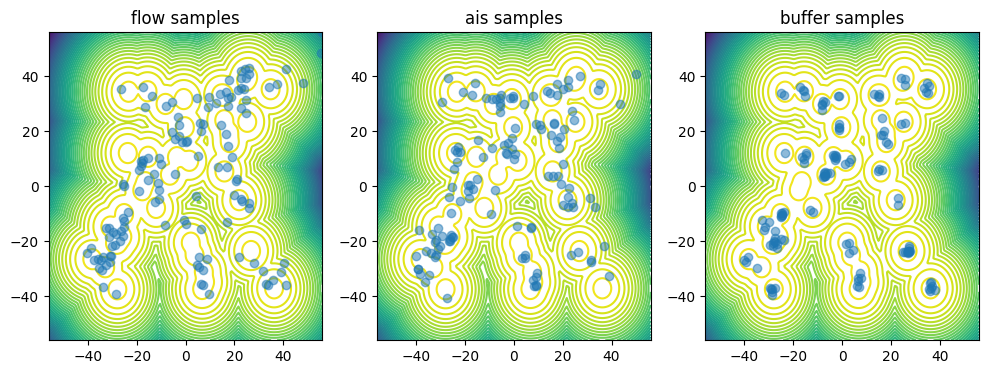

loss: 7.733477828612585, ess base: 0.2674964837748426,ess ais: 0.1319034584437792:  56%|█████▌    | 2225/4000 [02:06<03:57,  7.46it/s]   

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.376327746657566, ess base: 0.2548295980195449,ess ais: 0.06761307499186901:  56%|█████▌    | 2229/4000 [02:07<02:52, 10.26it/s]   

2 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.590165584722193, ess base: 0.3114209491430752,ess ais: 0.17117390762533363:  56%|█████▌    | 2233/4000 [02:07<02:12, 13.30it/s] 

2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.060217974495632, ess base: 0.3252715999477718,ess ais: 0.14442122124482865:  56%|█████▌    | 2241/4000 [02:07<01:40, 17.54it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 10.961323217696076, ess base: 0.23997714593172273,ess ais: 0.1158536174930012:  56%|█████▌    | 2249/4000 [02:08<01:34, 18.46it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.913448815487171, ess base: 0.28962935476552404,ess ais: 0.12174144167074945:  56%|█████▋    | 2255/4000 [02:08<01:43, 16.85it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.793086166974852, ess base: 0.30525876110954814,ess ais: 0.007874015748031496:  57%|█████▋    | 2261/4000 [02:08<01:35, 18.23it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 47.7342624630883, ess base: 0.3622860385150825,ess ais: 0.008951385591470724:  57%|█████▋    | 2267/4000 [02:09<01:31, 19.02it/s]  

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 55320083.02919286, ess base: 0.25528439782015255,ess ais: 0.0078125:  57%|█████▋    | 2273/4000 [02:09<01:36, 17.82it/s]          

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.720581573327496, ess base: 0.375935176088984,ess ais: 0.2516000805538515:  57%|█████▋    | 2277/4000 [02:09<01:35, 18.07it/s]    

1 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.893753787071718, ess base: 0.2511360477140543,ess ais: 0.08675835207871717:  57%|█████▋    | 2283/4000 [02:10<01:33, 18.33it/s]     

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.998447487288766, ess base: 0.3777802101440058,ess ais: 0.19074985936864083:  57%|█████▋    | 2289/4000 [02:10<01:32, 18.55it/s] 

2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.789684677037236, ess base: 0.3487472034015361,ess ais: 0.2012833491621309:  57%|█████▋    | 2293/4000 [02:10<01:41, 16.82it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.6444615576957915, ess base: 0.3411570659035054,ess ais: 0.11964503085302955:  58%|█████▊    | 2302/4000 [02:11<01:29, 19.03it/s]    

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 10.048827625158296, ess base: 0.3166897344529484,ess ais: 0.17474802787783325:  58%|█████▊    | 2308/4000 [02:11<01:28, 19.20it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 9.703821280279112, ess base: 0.37911843238697834,ess ais: 0.2558935156346771:  58%|█████▊    | 2312/4000 [02:11<01:36, 17.48it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.326890344647687, ess base: 0.2951377314819196,ess ais: 0.15447052256066368:  58%|█████▊    | 2322/4000 [02:12<01:27, 19.13it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.027281232988038, ess base: 0.33069234872789066,ess ais: 0.20990655991811932:  58%|█████▊    | 2324/4000 [02:12<01:39, 16.88it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan grad norm in replay step


loss: 8.584059370819762, ess base: 0.3447389531317242,ess ais: 0.16180354286603468:  58%|█████▊    | 2328/4000 [02:12<01:31, 18.25it/s] 

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step
nan loss in replay step


loss: inf, ess base: 0.31336715810328564,ess ais: 0.19163482528366113:  58%|█████▊    | 2334/4000 [02:12<01:23, 19.90it/s]               

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 9.81710253852432, ess base: 0.3232162589779192,ess ais: 0.17414838905454394:  58%|█████▊    | 2337/4000 [02:13<01:33, 17.80it/s]  

nan loss in replay step
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.30780685624822, ess base: 0.34524627488958437,ess ais: 0.00781251953825135:  59%|█████▊    | 2344/4000 [02:13<01:28, 18.73it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.539365810203764, ess base: 0.37966607504752226,ess ais: 0.24189346924972688:  59%|█████▊    | 2348/4000 [02:13<01:26, 19.16it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.865760287310488, ess base: 0.364545454242297,ess ais: 0.17998169320445725:  59%|█████▉    | 2354/4000 [02:14<01:33, 17.53it/s]  

1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.033789701829157, ess base: 0.34305635917100735,ess ais: 0.23418100007548762:  59%|█████▉    | 2364/4000 [02:14<01:33, 17.44it/s] 

2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.008615351333837, ess base: 0.3337684144886511,ess ais: 0.13864239309039697:  60%|█████▉    | 2382/4000 [02:15<01:27, 18.40it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 15.63182154250616, ess base: 0.30893069680568963,ess ais: 0.10960529478217905:  60%|█████▉    | 2388/4000 [02:15<01:24, 18.98it/s] 

2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.838682111113137, ess base: 0.3960273975705418,ess ais: 0.2392101529693835:  60%|█████▉    | 2394/4000 [02:16<01:23, 19.31it/s]   

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.5702952586508525, ess base: 0.2907255508882751,ess ais: 0.12644343337052225:  60%|█████▉    | 2398/4000 [02:16<01:21, 19.55it/s]     

2 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.615185846429158, ess base: 0.335437455939637,ess ais: 0.12482412296673165:  60%|██████    | 2400/4000 [02:16<01:34, 17.01it/s]  

nan loss in replay step


loss: 8.449284914080703, ess base: 0.32482985288799826,ess ais: 0.14773437937120631:  60%|██████    | 2404/4000 [02:16<01:32, 17.32it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step


loss: 8.569192975520032, ess base: 0.32965432473649026,ess ais: 0.01390795332010208:  60%|██████    | 2410/4000 [02:17<01:24, 18.73it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 9.272026877778607, ess base: 0.30294032801010873,ess ais: 0.16708211868208644:  60%|██████    | 2412/4000 [02:17<01:34, 16.78it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.203582132525574, ess base: 0.36867840868931473,ess ais: 0.2126254314520251:  60%|██████    | 2418/4000 [02:17<01:26, 18.39it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.5001466417618055, ess base: 0.35205223813597797,ess ais: 0.17037745763432627:  61%|██████    | 2422/4000 [02:17<01:23, 18.84it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.681444316399008, ess base: 0.321422594351715,ess ais: 0.007874015748031496:  61%|██████    | 2434/4000 [02:18<01:23, 18.75it/s]  

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 9.373069186062821, ess base: 0.31097796096976865,ess ais: 0.16479801971780092:  61%|██████    | 2440/4000 [02:18<01:22, 18.91it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.280879842434379, ess base: 0.3186336836433653,ess ais: 0.1571317319800456:  61%|██████    | 2444/4000 [02:19<01:23, 18.69it/s]  

1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.969642526477273, ess base: 0.35894180366770706,ess ais: 0.1977548893884101:  61%|██████    | 2448/4000 [02:19<01:23, 18.59it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.7983876966836005, ess base: 0.3448413848974713,ess ais: 0.18677553611632924:  61%|██████▏   | 2452/4000 [02:19<01:29, 17.33it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.39765421388897, ess base: 0.30820222519291146,ess ais: 0.1743533353415321:  61%|██████▏   | 2458/4000 [02:19<01:22, 18.58it/s]      

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.21107354565564, ess base: 0.2493599537987318,ess ais: 0.08813515056338152:  62%|██████▏   | 2464/4000 [02:20<01:21, 18.95it/s]    

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.84425302265544, ess base: 0.34150350501260734,ess ais: 0.15997981160406513:  62%|██████▏   | 2468/4000 [02:20<01:29, 17.03it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.9025780696181505, ess base: 0.2279502763988083,ess ais: 0.07431921054310717:  62%|██████▏   | 2478/4000 [02:20<01:19, 19.05it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.022285638548283, ess base: 0.3818630293771378,ess ais: 0.2415729407076994:  62%|██████▏   | 2484/4000 [02:21<01:19, 19.03it/s]   

2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 19.325365023131614, ess base: 0.31023211301636017,ess ais: 0.17585934991999455:  62%|██████▏   | 2492/4000 [02:21<01:23, 18.11it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.348341488770978, ess base: 0.39215739698883273,ess ais: 0.21092010496541896:  62%|██████▏   | 2496/4000 [02:21<01:20, 18.70it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.49887874333667, ess base: 0.36542999468317094,ess ais: 0.18326147907536874:  63%|██████▎   | 2503/4000 [02:22<01:16, 19.67it/s] 

nan loss in replay step
2 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan grad norm in replay step


loss: 7.997482644213279, ess base: 0.24907773992563648,ess ais: 0.034106407703237:  63%|██████▎   | 2507/4000 [02:22<01:21, 18.30it/s]  

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.439883854984572, ess base: 0.2829752466329316,ess ais: 0.007874015748031496:  63%|██████▎   | 2515/4000 [02:22<01:17, 19.26it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.8709177070517455, ess base: 0.3132398604120138,ess ais: 0.16338203233815352:  63%|██████▎   | 2521/4000 [02:23<01:29, 16.52it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.838440892286105, ess base: 0.2879235450657603,ess ais: 0.10173857897135645:  63%|██████▎   | 2527/4000 [02:23<01:20, 18.21it/s] 

2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.217581117979664, ess base: 0.3923168579740451,ess ais: 0.0078125:  63%|██████▎   | 2535/4000 [02:23<01:16, 19.11it/s]           

1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.24284604881573, ess base: 0.3631129288303629,ess ais: 0.18582375201496873:  64%|██████▎   | 2543/4000 [02:24<01:19, 18.43it/s]   

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.204716670480728, ess base: 0.3507888503199004,ess ais: 0.12111896013344513:  64%|██████▍   | 2553/4000 [02:24<01:14, 19.34it/s]  

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.751646665598747, ess base: 0.2972605275934734,ess ais: 0.0078125:  64%|██████▍   | 2561/4000 [02:25<01:18, 18.42it/s]            

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 2764459.4031351814, ess base: 0.25316700943502046,ess ais: 0.10395113888113744:  64%|██████▍   | 2565/4000 [02:25<01:18, 18.19it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.739723346525398, ess base: 0.26380987266348654,ess ais: 0.08585890090519807:  64%|██████▍   | 2571/4000 [02:25<01:21, 17.50it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.529672840721037, ess base: 0.3421364018946245,ess ais: 0.17390585630785224:  64%|██████▍   | 2575/4000 [02:26<01:20, 17.67it/s]   

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.84497158521592, ess base: 0.23741489917672776,ess ais: 0.04575060156894789:  65%|██████▍   | 2581/4000 [02:26<01:17, 18.22it/s]  

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.480890836762493, ess base: 0.3894133129741539,ess ais: 0.19855596162230477:  65%|██████▍   | 2593/4000 [02:27<01:15, 18.59it/s]  

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.598438234617532, ess base: 0.2771644017405747,ess ais: 0.08158266012466428:  65%|██████▍   | 2599/4000 [02:27<01:21, 17.19it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 10.230151259911679, ess base: 0.3141923769313248,ess ais: 0.0078125:  65%|██████▌   | 2603/4000 [02:27<01:18, 17.78it/s]          

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 11.132931867063892, ess base: 0.3626938487145193,ess ais: 0.18211756050558434:  65%|██████▌   | 2609/4000 [02:28<01:16, 18.08it/s]  

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.945750184293995, ess base: 0.338549276051094,ess ais: 0.14697857618926016:  65%|██████▌   | 2617/4000 [02:28<01:15, 18.28it/s]    

3 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.412777925696933, ess base: 0.44675181308954687,ess ais: 0.24628603564172083:  66%|██████▌   | 2623/4000 [02:28<01:21, 16.81it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.335888651318662, ess base: 0.3054918333148209,ess ais: 0.17752797411638782:  66%|██████▌   | 2627/4000 [02:29<01:21, 16.91it/s] 

2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.901312477054726, ess base: 0.4064970910864533,ess ais: 0.1737556056385338:  66%|██████▌   | 2639/4000 [02:29<01:26, 15.76it/s]   

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.949435248394183, ess base: 0.3964724124152873,ess ais: 0.22342002950338558:  66%|██████▌   | 2643/4000 [02:30<01:23, 16.20it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 11.700566099487922, ess base: 0.3430692487400661,ess ais: 0.13967843376995626:  66%|██████▋   | 2653/4000 [02:30<01:16, 17.54it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.8115342306505315, ess base: 0.3247845800291444,ess ais: 0.1814769431961448:  66%|██████▋   | 2659/4000 [02:31<01:15, 17.71it/s] 

nan loss in replay step
2 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step


loss: 104.75188148745225, ess base: 0.350559292067018,ess ais: 0.1667077259740703:  67%|██████▋   | 2665/4000 [02:31<01:20, 16.64it/s]   

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


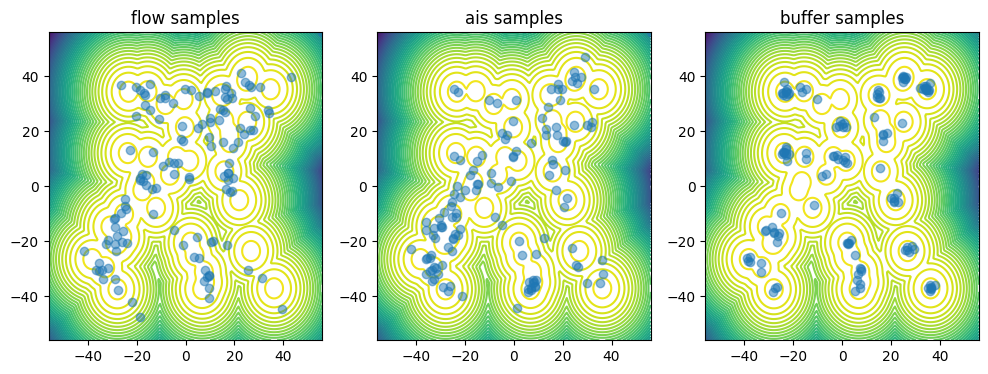

loss: 8.258492955895004, ess base: 0.34684555258530725,ess ais: 0.16915845646714103:  67%|██████▋   | 2673/4000 [02:32<02:27,  9.01it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.574772635634959, ess base: 0.3092157614110319,ess ais: 0.15173076324371496:  67%|██████▋   | 2683/4000 [02:33<01:23, 15.68it/s]     

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.638374926454557, ess base: 0.3258333538660255,ess ais: 0.16786764948227398:  67%|██████▋   | 2696/4000 [02:34<01:09, 18.79it/s]  

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.035962602165936, ess base: 0.33492814824213313,ess ais: 0.22003821089486045:  68%|██████▊   | 2703/4000 [02:34<01:08, 18.96it/s]    

nan grad norm in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 8.179681455144646, ess base: 0.34092319039330005,ess ais: 0.18525698754198225:  68%|██████▊   | 2709/4000 [02:34<01:11, 17.96it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.155935175828834, ess base: 0.36725952870469,ess ais: 0.19797993432210362:  68%|██████▊   | 2713/4000 [02:35<01:09, 18.60it/s]    

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step
nan loss in replay step


loss: 7.817110155476772, ess base: 0.39001898927154727,ess ais: 0.21140450394670507:  68%|██████▊   | 2722/4000 [02:35<01:04, 19.83it/s] 

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step
nan loss in replay step


loss: 8.349829925040623, ess base: 0.37107574507275887,ess ais: 0.007874015748031496:  68%|██████▊   | 2728/4000 [02:36<01:25, 14.91it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan grad norm in replay step


loss: 9.40384030782984e+130, ess base: 0.343872187113222,ess ais: 0.1557322160647121:  68%|██████▊   | 2732/4000 [02:36<01:26, 14.62it/s]

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 10.002604762773666, ess base: 0.2718741251173844,ess ais: 0.11657970258262551:  68%|██████▊   | 2740/4000 [02:36<01:29, 14.13it/s] 

nan loss in replay step
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.705741947647137, ess base: 0.3457976130837618,ess ais: 0.20555784378890216:  69%|██████▊   | 2742/4000 [02:37<01:26, 14.62it/s]  

nan loss in replay step
3 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.268285608276145, ess base: 0.29368697208186495,ess ais: 0.07921995666450848:  69%|██████▊   | 2748/4000 [02:37<01:25, 14.57it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 7.783169638725891, ess base: 0.35456575385551986,ess ais: 0.2008768850917051:  69%|██████▉   | 2754/4000 [02:37<01:13, 17.00it/s]       

nan grad norm in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan grad norm in replay step


loss: 1220.1745764877526, ess base: 0.3717112425609396,ess ais: 0.0078125:  69%|██████▉   | 2764/4000 [02:38<01:10, 17.48it/s]             

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.547144293441072, ess base: 0.29559965371528696,ess ais: 0.13719766791260915:  69%|██████▉   | 2768/4000 [02:38<01:09, 17.63it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.114278496764598, ess base: 0.37889316508482285,ess ais: 0.22768886897644947:  69%|██████▉   | 2774/4000 [02:39<01:11, 17.22it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 14.119721752062524, ess base: 0.307573008963598,ess ais: 0.13210102363589354:  69%|██████▉   | 2778/4000 [02:39<01:08, 17.83it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 15.354496848714994, ess base: 0.34408144476395824,ess ais: 0.15746662682219628:  70%|██████▉   | 2782/4000 [02:39<01:07, 18.07it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.212052418760239, ess base: 0.12422788893423213,ess ais: 0.0078125:  70%|██████▉   | 2786/4000 [02:39<01:12, 16.83it/s]           

2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.120534660151906, ess base: 0.36293325748421595,ess ais: 0.1547512190322105:  70%|██████▉   | 2792/4000 [02:40<01:06, 18.18it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.6575222897313875, ess base: 0.36567295470823025,ess ais: 0.16806985646738712:  70%|██████▉   | 2796/4000 [02:40<01:07, 17.92it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.746573600964618, ess base: 0.26826468023292377,ess ais: 0.045783340957160995:  70%|███████   | 2802/4000 [02:40<01:10, 16.87it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 11.421745257031064, ess base: 0.3635534446070011,ess ais: 0.2184949954479007:  70%|███████   | 2810/4000 [02:41<01:04, 18.40it/s]  

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 11.398604894300435, ess base: 0.3620744508871508,ess ais: 0.16456110516152697:  70%|███████   | 2814/4000 [02:41<01:09, 17.17it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.765564901167947, ess base: 0.34260791472348423,ess ais: 0.17310303352775397:  70%|███████   | 2820/4000 [02:41<01:03, 18.52it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.164926969637442, ess base: 0.33591920686022864,ess ais: 0.1039604018247099:  71%|███████   | 2824/4000 [02:41<01:07, 17.40it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 11.377136896923481, ess base: 0.35658887366441044,ess ais: 0.19551354231207854:  71%|███████   | 2828/4000 [02:42<01:04, 18.14it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.718133616561824, ess base: 0.4471780072183264,ess ais: 0.0078125:  71%|███████   | 2832/4000 [02:42<01:05, 17.85it/s]            

2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 9.56906174486799, ess base: 0.2802381614134451,ess ais: 0.12213671862814607:  71%|███████   | 2836/4000 [02:42<01:11, 16.38it/s]   

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.81280921012968, ess base: 0.3735532944453574,ess ais: 0.18607824111823743:  71%|███████   | 2840/4000 [02:42<01:05, 17.59it/s]  

1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.531940870310319, ess base: 0.31539805882881156,ess ais: 0.16042330952347406:  71%|███████▏  | 2850/4000 [02:43<01:01, 18.57it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.638434169984086, ess base: 0.32453655368431117,ess ais: 0.12989352725258957:  71%|███████▏  | 2856/4000 [02:43<01:04, 17.67it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.836057016499579, ess base: 0.27750578930954756,ess ais: 0.080131394821006:  72%|███████▏  | 2862/4000 [02:43<01:02, 18.32it/s]  

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.987791909855559, ess base: 0.33255347992262513,ess ais: 0.21859644928635885:  72%|███████▏  | 2870/4000 [02:44<01:02, 17.96it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 68.33772493146785, ess base: 0.35877467185964973,ess ais: 0.2272807427422324:  72%|███████▏  | 2876/4000 [02:44<01:00, 18.72it/s] 

2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.758003898400972, ess base: 0.3891103638170697,ess ais: 0.22195172454611967:  72%|███████▏  | 2886/4000 [02:45<00:57, 19.37it/s]   

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.502087379450768, ess base: 0.39657610441757724,ess ais: 0.007849688392913397:  72%|███████▏  | 2898/4000 [02:46<01:01, 17.78it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.6469309192674695, ess base: 0.338307570566923,ess ais: 0.16635358324699084:  73%|███████▎  | 2906/4000 [02:46<00:59, 18.34it/s]  

2 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.091433858616437, ess base: 0.39386971323121456,ess ais: 0.20946880263332252:  73%|███████▎  | 2910/4000 [02:46<00:58, 18.65it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 33.86836784912242, ess base: 0.33591177902089,ess ais: 0.15144089360895846:  73%|███████▎  | 2916/4000 [02:47<01:01, 17.61it/s]    

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.347193791941127, ess base: 0.37040196831036815,ess ais: 0.17730244652239993:  73%|███████▎  | 2922/4000 [02:47<00:57, 18.60it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.254177887753972, ess base: 0.33713363297094,ess ais: 0.1433522496769287:  73%|███████▎  | 2930/4000 [02:47<00:55, 19.14it/s]      

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.534552622663499, ess base: 0.32114003014016984,ess ais: 0.12743647516279066:  73%|███████▎  | 2935/4000 [02:48<00:54, 19.50it/s]

nan loss in replay step


loss: 7.956046808253292, ess base: 0.38520457892364734,ess ais: 0.19654270068242805:  74%|███████▎  | 2941/4000 [02:48<00:58, 18.08it/s]     

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.973032705655133e+31, ess base: 0.3945735155461235,ess ais: 0.0078125:  74%|███████▎  | 2945/4000 [02:48<00:56, 18.58it/s]       

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.595071908833948, ess base: 0.3033504302572767,ess ais: 0.13513324618066286:  74%|███████▍  | 2951/4000 [02:48<00:55, 18.78it/s] 

nan loss in replay step
2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 9.610820904108193, ess base: 0.4248334265420153,ess ais: 0.16463633354531576:  74%|███████▍  | 2955/4000 [02:49<01:00, 17.40it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.037196872226096, ess base: 0.37146410929646495,ess ais: 0.01331932502785398:  74%|███████▍  | 2959/4000 [02:49<00:58, 17.93it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 142.09651342791946, ess base: 0.3634067683222325,ess ais: 0.2024864054356999:  74%|███████▍  | 2965/4000 [02:49<00:56, 18.41it/s]  

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 10.820634026157808, ess base: 0.3124432378432754,ess ais: 0.0640351232778861:  74%|███████▍  | 2969/4000 [02:49<01:00, 16.95it/s] 

2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 13.282686124055719, ess base: 0.2822890742668755,ess ais: 0.13357399633620387:  74%|███████▍  | 2979/4000 [02:50<00:53, 18.98it/s]  

1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.541701964549748, ess base: 0.3157292736122993,ess ais: 0.008235178890717171:  75%|███████▍  | 2981/4000 [02:50<01:00, 16.85it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.5856642215862, ess base: 0.34861183022890657,ess ais: 0.007874015748031496:  75%|███████▍  | 2985/4000 [02:50<00:56, 17.83it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.964050356027922, ess base: 0.3259570378527416,ess ais: 0.18811927765889475:  75%|███████▍  | 2990/4000 [02:51<00:54, 18.65it/s]   

2 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.543691586555052, ess base: 0.2727278024200416,ess ais: 0.11673015731842441:  75%|███████▍  | 2994/4000 [02:51<00:56, 17.69it/s] 

nan loss in replay step


loss: 8.537084190491697, ess base: 0.3297116828811036,ess ais: 0.15359593745294067:  75%|███████▌  | 3000/4000 [02:51<00:53, 18.73it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.136407617909638, ess base: 0.32561942903775115,ess ais: 0.15903004306636734:  75%|███████▌  | 3006/4000 [02:51<00:56, 17.58it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 9.661368440874286, ess base: 0.3359495213834202,ess ais: 0.17435926712422592:  75%|███████▌  | 3012/4000 [02:52<00:52, 18.76it/s]  

2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 11.973077622304388, ess base: 0.18355744030846693,ess ais: 0.007874015748031496:  75%|███████▌  | 3018/4000 [02:52<00:51, 19.22it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 9.050535173341487, ess base: 0.31349730441446,ess ais: 0.12415836026928248:  76%|███████▌  | 3022/4000 [02:52<00:54, 17.80it/s]     

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 429.19756593073447, ess base: 0.3652689877714902,ess ais: 0.19349193474729343:  76%|███████▌  | 3026/4000 [02:53<00:53, 18.16it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 12.05592537042514, ess base: 0.3084244071357239,ess ais: 0.10737483022413809:  76%|███████▌  | 3030/4000 [02:53<00:59, 16.20it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.855693350231203, ess base: 0.2892416452725048,ess ais: 0.11395221120568072:  76%|███████▌  | 3034/4000 [02:53<00:54, 17.62it/s]  

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 771.1238042151758, ess base: 0.2178261498774825,ess ais: 0.1023857954625202:  76%|███████▌  | 3043/4000 [02:53<00:49, 19.38it/s]  

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.414393579806024, ess base: 0.3107522431446796,ess ais: 0.15805898098720753:  76%|███████▌  | 3049/4000 [02:54<00:51, 18.47it/s]  

nan grad norm in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.549084521866398, ess base: 0.2868005381683353,ess ais: 0.007874015748031496:  76%|███████▋  | 3053/4000 [02:54<00:50, 18.78it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.823684982606021, ess base: 0.31875568342430016,ess ais: 0.13612315661961552:  77%|███████▋  | 3061/4000 [02:54<00:48, 19.28it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.017184036413397, ess base: 0.34337650420875204,ess ais: 0.1657210282748739:  77%|███████▋  | 3071/4000 [02:55<00:50, 18.47it/s]     

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.006966908999477, ess base: 0.3544397650798008,ess ais: 0.0078125:  77%|███████▋  | 3076/4000 [02:55<00:47, 19.46it/s]           

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 8.639603925845954, ess base: 0.31068851116897134,ess ais: 0.12233195601716734:  77%|███████▋  | 3080/4000 [02:56<00:50, 18.05it/s]    

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.727048310786579, ess base: 0.31110991097723156,ess ais: 0.1540891250365561:  77%|███████▋  | 3086/4000 [02:56<00:50, 18.08it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.0760703966197, ess base: 0.35717913350534997,ess ais: 0.0078125:  77%|███████▋  | 3092/4000 [02:56<00:52, 17.46it/s]            

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 8.25340089894435, ess base: 0.420786557184093,ess ais: 0.21770678551497666:  78%|███████▊  | 3104/4000 [02:57<00:47, 18.87it/s]      

2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 22.84391957956026, ess base: 0.4096981105891762,ess ais: 0.0078125:  78%|███████▊  | 3110/4000 [02:57<00:46, 19.02it/s]            

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


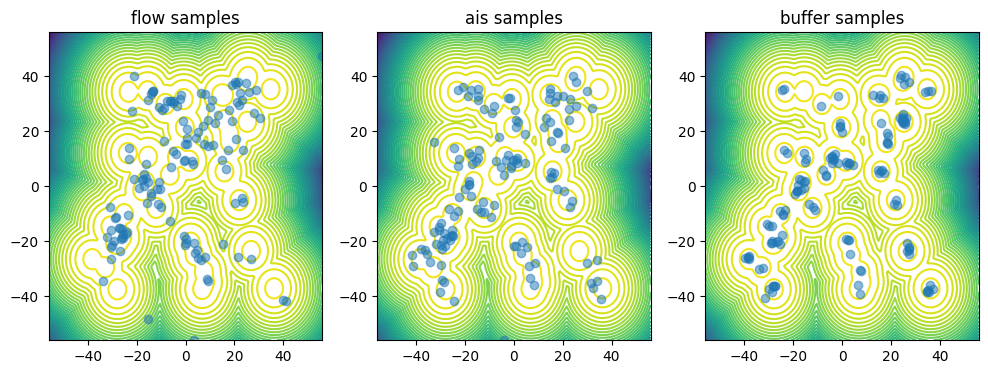

loss: 8.076158595103028, ess base: 0.4021497982083054,ess ais: 0.219259566659412:  78%|███████▊  | 3114/4000 [02:58<01:59,  7.39it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 9.56871518394004, ess base: 0.40639657468963786,ess ais: 0.17742235949083723:  78%|███████▊  | 3118/4000 [02:58<01:26, 10.24it/s]  

2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 9.779799108859326, ess base: 0.32970222362879453,ess ais: 0.17874935106072143:  78%|███████▊  | 3127/4000 [02:59<00:53, 16.37it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 7.866827267833535, ess base: 0.30607232401167034,ess ais: 0.09816353872030924:  78%|███████▊  | 3136/4000 [02:59<00:47, 18.20it/s]

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.040297170623434, ess base: 0.30953028367189356,ess ais: 0.15153898783396094:  79%|███████▊  | 3146/4000 [03:00<00:46, 18.45it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.613146021927097, ess base: 0.37816085668928,ess ais: 0.2551276237230603:  79%|███████▉  | 3152/4000 [03:00<00:45, 18.83it/s]    

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.663254388474899, ess base: 0.32714089728067064,ess ais: 0.1509844161178887:  79%|███████▉  | 3160/4000 [03:01<00:43, 19.25it/s]  

1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.462415365007256, ess base: 0.362801296181273,ess ais: 0.1767931160831659:  79%|███████▉  | 3162/4000 [03:01<00:49, 17.03it/s]  

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.667460629717089, ess base: 0.3154019415480185,ess ais: 0.11792074616500066:  79%|███████▉  | 3166/4000 [03:01<00:46, 18.09it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.606129660360004, ess base: 0.40215851203124126,ess ais: 0.25928050967517324:  79%|███████▉  | 3170/4000 [03:01<00:44, 18.48it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.662596605556175, ess base: 0.3136266134434684,ess ais: 0.15188752144170795:  80%|███████▉  | 3182/4000 [03:02<00:43, 18.66it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 10.722677070367412, ess base: 0.29457292677404345,ess ais: 0.0078125:  80%|███████▉  | 3187/4000 [03:02<00:42, 19.23it/s]        

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 8.975367154420969, ess base: 0.2896613556952579,ess ais: 0.16108812713677453:  80%|███████▉  | 3191/4000 [03:02<00:45, 17.62it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: inf, ess base: 0.3214116375950925,ess ais: 0.11668986903904205:  80%|████████  | 3201/4000 [03:03<00:41, 19.10it/s]                

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan grad norm in replay step
nan loss in replay step


loss: 8.949886725070257, ess base: 0.28125172193425996,ess ais: 0.13669040243774075:  80%|████████  | 3206/4000 [03:03<00:46, 16.92it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.158289724595749, ess base: 0.39714318439568946,ess ais: 0.19203880330949286:  80%|████████  | 3212/4000 [03:04<00:45, 17.34it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 51.67825292423656, ess base: 0.3089591616171983,ess ais: 0.05852356075993406:  80%|████████  | 3216/4000 [03:04<00:52, 15.06it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 10.126191264277786, ess base: 0.34032851716640483,ess ais: 0.2191183515308678:  80%|████████  | 3220/4000 [03:04<00:50, 15.40it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 9.269665856495749, ess base: 0.3172232967838126,ess ais: 0.0078125:  81%|████████  | 3222/4000 [03:04<01:00, 12.82it/s]           

nan loss in replay step
nan loss in replay step


loss: 13.742068718754684, ess base: 0.33308924534713963,ess ais: 0.0078125:  81%|████████  | 3224/4000 [03:05<00:59, 12.99it/s]         

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.300246968261188, ess base: 0.3783331202942863,ess ais: 0.20583531802152855:  81%|████████  | 3230/4000 [03:05<01:05, 11.82it/s] 

3 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.911459854237333, ess base: 0.2907412671494795,ess ais: 0.15532368284875697:  81%|████████  | 3234/4000 [03:05<01:05, 11.78it/s]  

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 10.259466288951526, ess base: 0.3950208780279746,ess ais: 0.19989371324599292:  81%|████████  | 3242/4000 [03:06<00:49, 15.41it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.717981685830792, ess base: 0.369500996506295,ess ais: 0.10418606569882338:  81%|████████  | 3246/4000 [03:06<00:44, 17.09it/s]  

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.944126363168529, ess base: 0.3574028248077793,ess ais: 0.17822788247786409:  81%|████████▏ | 3250/4000 [03:06<00:41, 17.99it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 3298.2351485631893, ess base: 0.07866396357124088,ess ais: 0.007874677786744846:  81%|████████▏ | 3256/4000 [03:07<00:40, 18.33it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.
nan grad norm in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 9.625934183304343, ess base: 0.32988783495625756,ess ais: 0.2054081542091863:  82%|████████▏ | 3264/4000 [03:07<00:41, 17.89it/s]   

1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.060401754370314, ess base: 0.3382806747947384,ess ais: 0.1566719961496507:  82%|████████▏ | 3277/4000 [03:08<00:37, 19.12it/s]       

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 7.977454859805942, ess base: 0.38226224472594744,ess ais: 0.22918458039935766:  82%|████████▏ | 3279/4000 [03:08<00:37, 19.24it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step


loss: 7.458201160417356, ess base: 0.32123050912889994,ess ais: 0.1791900393793771:  82%|████████▏ | 3285/4000 [03:08<00:38, 18.37it/s] 

nan loss in replay step
nan loss in replay step


loss: 8.027910914915946, ess base: 0.31394033166771396,ess ais: 0.15192201031505187:  82%|████████▏ | 3292/4000 [03:09<00:37, 18.98it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.355672397561846, ess base: 0.36220142682957074,ess ais: 0.19163459472609046:  82%|████████▏ | 3294/4000 [03:09<00:37, 18.89it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.852530004884399, ess base: 0.3416324961633886,ess ais: 0.1380334141381019:  82%|████████▏ | 3297/4000 [03:09<00:36, 19.26it/s]  

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 13.611588427534917, ess base: 0.3186691972895721,ess ais: 0.15553735234211613:  83%|████████▎ | 3306/4000 [03:09<00:38, 17.95it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 16.324700479051426, ess base: 0.19440369106869326,ess ais: 0.0467448810028059:  83%|████████▎ | 3310/4000 [03:10<00:38, 18.05it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.843959236485107, ess base: 0.22634437997983012,ess ais: 0.05398720553382528:  83%|████████▎ | 3312/4000 [03:10<00:44, 15.41it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.192662638326665, ess base: 0.17470053887592923,ess ais: 0.04302601061364562:  83%|████████▎ | 3316/4000 [03:10<00:41, 16.61it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.395849765834876, ess base: 0.4265991550784059,ess ais: 0.26924073683670885:  83%|████████▎ | 3320/4000 [03:10<00:38, 17.58it/s] 

3 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.20783454339743, ess base: 0.4170134045879265,ess ais: 0.22832208537732768:  83%|████████▎ | 3326/4000 [03:11<00:39, 17.00it/s]  

3 nan/inf samples/log-probs/log-weights encountered at chain init.
nan grad norm in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 10.930818730502816, ess base: 0.4008455873001427,ess ais: 0.0078125:  83%|████████▎ | 3331/4000 [03:11<00:36, 18.48it/s]          

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.991274893468345, ess base: 0.33536491729193685,ess ais: 0.18091876454856884:  83%|████████▎ | 3335/4000 [03:11<00:36, 18.35it/s] 

2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.097844979132961, ess base: 0.3847001291328642,ess ais: 0.19194789773365012:  84%|████████▎ | 3347/4000 [03:12<00:34, 18.70it/s]  

nan loss in replay step


loss: 7.259533973173097, ess base: 0.4058863660250138,ess ais: 0.22736810157203055:  84%|████████▍ | 3353/4000 [03:12<00:34, 18.69it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.510805692856085, ess base: 0.36620766284857986,ess ais: 0.11136435934181028:  84%|████████▍ | 3365/4000 [03:13<00:33, 19.05it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 13.931296975007974, ess base: 0.3333219369061097,ess ais: 0.0078125:  84%|████████▍ | 3369/4000 [03:13<00:35, 17.73it/s]          

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.440235802548943, ess base: 0.1865627305291661,ess ais: 0.01761931076503041:  84%|████████▍ | 3373/4000 [03:13<00:34, 18.28it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.587789060548964, ess base: 0.36748816929357125,ess ais: 0.20125973183314713:  84%|████████▍ | 3379/4000 [03:13<00:34, 17.96it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.370810598869402, ess base: 0.353097034226522,ess ais: 0.16337390793850232:  85%|████████▍ | 3383/4000 [03:14<00:36, 16.97it/s]  

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.921887158645765, ess base: 0.3680687150777832,ess ais: 0.181238807242703:  85%|████████▍ | 3389/4000 [03:14<00:34, 17.67it/s]   

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.663685755666482, ess base: 0.40713891424297116,ess ais: 0.23000042084420694:  85%|████████▍ | 3395/4000 [03:15<00:36, 16.72it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.111813148136662, ess base: 0.37046586711787777,ess ais: 0.20604106076254142:  85%|████████▍ | 3399/4000 [03:15<00:45, 13.11it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.592859917191133, ess base: 0.2597410868698668,ess ais: 0.05552143472276016:  85%|████████▌ | 3404/4000 [03:15<00:36, 16.11it/s] 

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.720691827432998, ess base: 0.38133593917255076,ess ais: 0.20084943525233198:  86%|████████▌ | 3420/4000 [03:16<00:31, 18.55it/s]   

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 9.55258588160969, ess base: 0.3921685481744315,ess ais: 0.2516686164343596:  86%|████████▌ | 3442/4000 [03:17<00:29, 19.08it/s]    

2 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 12.534859942226136, ess base: 0.419876072090529,ess ais: 0.23199279712185586:  86%|████████▌ | 3447/4000 [03:17<00:28, 19.72it/s] 

nan loss in replay step
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 11.93279824414706, ess base: 0.3711559195389974,ess ais: 0.0909290538788831:  86%|████████▋ | 3451/4000 [03:18<00:28, 19.22it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.994332087163967, ess base: 0.4617079591648322,ess ais: 0.2668514065454734:  86%|████████▋ | 3455/4000 [03:18<00:31, 17.11it/s]    

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.2648541513742, ess base: 0.356883337958645,ess ais: 0.007812500000373222:  87%|████████▋ | 3467/4000 [03:19<00:29, 18.31it/s]   

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 11.296653738555463, ess base: 0.16256655010204574,ess ais: 0.028962356990760833:  87%|████████▋ | 3476/4000 [03:19<00:28, 18.45it/s]

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 17.18998841576545, ess base: 0.22463668287154095,ess ais: 0.03936323559787097:  87%|████████▋ | 3486/4000 [03:20<00:27, 18.59it/s]  

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.03444812352782, ess base: 0.36986462336379355,ess ais: 0.007812500016370082:  87%|████████▋ | 3490/4000 [03:20<00:27, 18.86it/s]  

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.21320579032058, ess base: 0.40550273931374037,ess ais: 0.20383712193273773:  88%|████████▊ | 3504/4000 [03:21<00:29, 16.98it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 9.781703871137662, ess base: 0.44136466206872255,ess ais: 0.24332350316545448:  88%|████████▊ | 3508/4000 [03:21<00:27, 17.78it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 8.13099092249054, ess base: 0.3476893048914536,ess ais: 0.15922595199183925:  88%|████████▊ | 3515/4000 [03:21<00:25, 18.85it/s]  

2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 11.579389796271066, ess base: 0.34525656092036566,ess ais: 0.1740113836184782:  88%|████████▊ | 3523/4000 [03:22<00:26, 18.27it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: inf, ess base: 0.3008754333435378,ess ais: 0.0078125:  88%|████████▊ | 3527/4000 [03:22<00:25, 18.42it/s]                          

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 9.02082300871571, ess base: 0.34987876656528777,ess ais: 0.15542403607043026:  88%|████████▊ | 3532/4000 [03:22<00:26, 17.78it/s]

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.2109352036130225, ess base: 0.43678673993878736,ess ais: 0.24779507647796878:  88%|████████▊ | 3538/4000 [03:22<00:23, 19.39it/s]

nan loss in replay step
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan grad norm in replay step


loss: 7.709306952914258, ess base: 0.40094004085468254,ess ais: 0.23057470973143215:  88%|████████▊ | 3540/4000 [03:23<00:26, 17.43it/s] 

nan loss in replay step
2 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 10.57271925576471, ess base: 0.4000050367584203,ess ais: 0.1867334346567755:  89%|████████▊ | 3545/4000 [03:23<00:24, 18.48it/s]      

1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.9255575265128, ess base: 0.34552579533164074,ess ais: 0.17012929032147034:  89%|████████▊ | 3549/4000 [03:23<00:24, 18.55it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.567709897605164, ess base: 0.34778127477170845,ess ais: 0.16427928870493236:  89%|████████▉ | 3553/4000 [03:23<00:26, 16.85it/s] 

2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


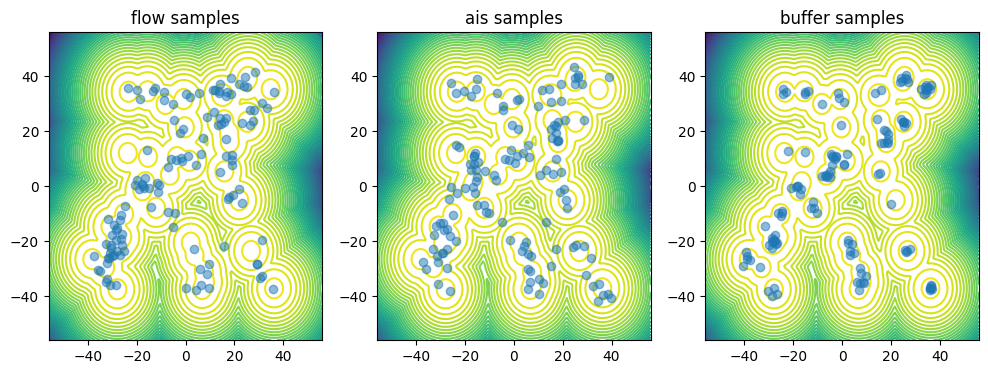

loss: 8.931039739917884, ess base: 0.32976880233291245,ess ais: 0.15479101717516608:  89%|████████▉ | 3566/4000 [03:25<00:29, 14.49it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 908.5911911943081, ess base: 0.17651229223784712,ess ais: 0.028205142759752392:  89%|████████▉ | 3568/4000 [03:25<00:30, 14.12it/s] 

2 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 4.519260368119293e+168, ess base: 0.34014510507987517,ess ais: 0.16426161485545868:  89%|████████▉ | 3579/4000 [03:25<00:23, 18.30it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan grad norm in replay step


loss: 8.507275672060223, ess base: 0.3556601792576258,ess ais: 0.10277498515464333:  90%|████████▉ | 3583/4000 [03:26<00:24, 17.17it/s]      

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 13.267888545555513, ess base: 0.3715583413534481,ess ais: 0.14778598091176431:  90%|████████▉ | 3587/4000 [03:26<00:25, 16.42it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.456041496702735, ess base: 0.40439915454419423,ess ais: 0.23844277461934402:  90%|████████▉ | 3591/4000 [03:26<00:23, 17.68it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 9.412002413156698, ess base: 0.3103034105183071,ess ais: 0.11127843229702597:  90%|████████▉ | 3595/4000 [03:26<00:24, 16.41it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: nan, ess base: 0.2395749174896822,ess ais: 0.007874015748031496:  90%|████████▉ | 3599/4000 [03:27<00:23, 17.43it/s]               

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan grad norm in replay step
nan loss in replay step


loss: 8.109307958366962, ess base: 0.43200881835624527,ess ais: 0.2352536021760409:  90%|█████████ | 3603/4000 [03:27<00:22, 17.92it/s] 

2 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.208957854647497, ess base: 0.3728748202840637,ess ais: 0.23681215517104515:  90%|█████████ | 3608/4000 [03:27<00:22, 17.62it/s]  

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.772813506467793, ess base: 0.4120012511689943,ess ais: 0.23578827175516787:  90%|█████████ | 3614/4000 [03:27<00:21, 17.57it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 1.611344597641355e+162, ess base: 0.4036318180770674,ess ais: 0.011275313504611884:  91%|█████████ | 3623/4000 [03:28<00:19, 19.09it/s]

nan loss in replay step
nan grad norm in replay step


loss: 7.888922511662541, ess base: 0.37585995123185517,ess ais: 0.07145124432437638:  91%|█████████ | 3627/4000 [03:28<00:21, 17.20it/s]     

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.09414924431684, ess base: 0.3574036343375086,ess ais: 0.007812506456999458:  91%|█████████ | 3634/4000 [03:29<00:19, 18.67it/s]  

nan loss in replay step
2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.2759526890031445, ess base: 0.3567184748787962,ess ais: 0.20710888389126778:  91%|█████████ | 3637/4000 [03:29<00:21, 17.08it/s]

nan loss in replay step


loss: 7.651346688774947, ess base: 0.3506186448872067,ess ais: 0.19696583832898507:  91%|█████████ | 3641/4000 [03:29<00:20, 17.36it/s] 

2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.985761698622408, ess base: 0.3509263684711261,ess ais: 0.10125527690675172:  91%|█████████ | 3645/4000 [03:29<00:19, 17.83it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 172.32605497393857, ess base: 0.4515049828948454,ess ais: 0.24241306548399075:  91%|█████████▏| 3653/4000 [03:30<00:20, 17.22it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.5598018847266335, ess base: 0.3508153283579723,ess ais: 0.20793030992489864:  91%|█████████▏| 3659/4000 [03:30<00:19, 17.21it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.126574408732775, ess base: 0.40647886910350567,ess ais: 0.2628886860778472:  92%|█████████▏| 3663/4000 [03:30<00:18, 18.08it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.930808838740356, ess base: 0.4186650806460738,ess ais: 0.29000880577964416:  92%|█████████▏| 3671/4000 [03:31<00:17, 18.36it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.946108642655635, ess base: 0.37699691458161577,ess ais: 0.18531221267346346:  92%|█████████▏| 3673/4000 [03:31<00:20, 15.91it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 15.765397969882855, ess base: 0.401401111282554,ess ais: 0.17751759862375915:  92%|█████████▏| 3679/4000 [03:31<00:19, 16.83it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.664888505459668, ess base: 0.43322984103079537,ess ais: 0.19042848505619248:  92%|█████████▏| 3683/4000 [03:31<00:18, 16.69it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.231428022535226, ess base: 0.43289678968022155,ess ais: 0.2501046274628393:  92%|█████████▏| 3687/4000 [03:32<00:18, 17.28it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 28.89300738695742, ess base: 0.3528732645438224,ess ais: 0.007812500000094733:  92%|█████████▏| 3691/4000 [03:32<00:16, 18.18it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: inf, ess base: 0.34486223476391636,ess ais: 0.0078125:  92%|█████████▏| 3694/4000 [03:32<00:17, 17.51it/s]                              

nan loss in replay step
nan loss in replay step
nan loss in replay step
nan loss in replay step
nan loss in replay step
nan loss in replay step
nan grad norm in replay step
nan loss in replay step
nan loss in replay step
nan loss in replay step
nan loss in replay step
nan grad norm in replay step
nan loss in replay step


loss: 2519.4889699273895, ess base: 0.13628776746067786,ess ais: 0.016587201318197724:  93%|█████████▎| 3702/4000 [03:32<00:11, 26.45it/s]

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step
nan loss in replay step
nan loss in replay step
nan loss in replay step
nan loss in replay step
nan loss in replay step
2 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step
nan loss in replay step
nan loss in replay step
nan loss in replay step
nan loss in replay step
nan loss in replay step
nan loss in replay step
nan loss in replay step
nan loss in replay step
nan loss in replay step
nan loss in replay step
nan loss in replay step
nan loss in replay step
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step
nan loss in replay step
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: inf, ess base: 0.101591220265938,ess ais: 0.0078125:  93%|█████████▎| 3709/4000 [03:33<00:10, 27.28it/s]                            

nan loss in replay step
nan loss in replay step
nan loss in replay step
nan loss in replay step
2 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step
nan loss in replay step
nan loss in replay step
nan loss in replay step
nan loss in replay step
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step
nan loss in replay step
nan loss in replay step
nan loss in replay step
nan loss in replay step
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step
nan grad norm in replay step


loss: 6.4588043418278645e+47, ess base: 0.20118297427241671,ess ais: 0.007812506645142306:  93%|█████████▎| 3715/4000 [03:33<00:10, 26.95it/s]

nan grad norm in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan grad norm in replay step
nan grad norm in replay step
nan loss in replay step
nan grad norm in replay step
nan loss in replay step
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan grad norm in replay step
nan grad norm in replay step
nan loss in replay step


loss: 1.3318496294733838e+42, ess base: 0.2695778485479761,ess ais: 0.007883575786747476:  93%|█████████▎| 3718/4000 [03:33<00:12, 22.48it/s] 

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 1.905842669541547e+29, ess base: 0.2625104446178118,ess ais: 0.0078125:  93%|█████████▎| 3721/4000 [03:33<00:13, 20.63it/s]            

nan grad norm in replay step
nan loss in replay step
nan loss in replay step


loss: inf, ess base: 0.2259112753061046,ess ais: 0.12186364162047988:  93%|█████████▎| 3724/4000 [03:33<00:14, 18.76it/s]                    

nan loss in replay step
2 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step
nan loss in replay step
nan grad norm in replay step
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step


loss: 94773551294122.33, ess base: 0.1139927016267674,ess ais: 0.02899170326706194:  93%|█████████▎| 3730/4000 [03:34<00:13, 20.39it/s] 

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
4 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 2047732072.748356, ess base: 0.14908708125048561,ess ais: 0.05343469699942775:  93%|█████████▎| 3733/4000 [03:34<00:14, 17.85it/s]     

nan grad norm in replay step
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 2931840502.5666966, ess base: 0.13361524184818857,ess ais: 0.07556079899236366:  93%|█████████▎| 3737/4000 [03:34<00:14, 18.49it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.
4 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 215.99802888101914, ess base: 0.08951540957124039,ess ais: 0.008333333333333333:  94%|█████████▎| 3742/4000 [03:34<00:13, 19.66it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
5 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
4 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
8 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step
12 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: inf, ess base: 0.09733509071515345,ess ais: 0.008928571428571428:  94%|█████████▎| 3745/4000 [03:34<00:13, 18.67it/s]               

8 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step
11 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
16 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
13 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 452.0963881639994, ess base: 0.1683529232319337,ess ais: 0.10026153799266979:  94%|█████████▍| 3751/4000 [03:35<00:11, 21.51it/s]      

nan grad norm in replay step
12 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step
10 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step
nan grad norm in replay step
11 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step
nan loss in replay step
16 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step
nan loss in replay step
10 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step
nan loss in replay step
5 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: inf, ess base: 0.11330534029254136,ess ais: 0.008849557522123894:  94%|█████████▍| 3757/4000 [03:35<00:10, 22.86it/s]            

nan loss in replay step
nan loss in replay step
nan loss in replay step
nan loss in replay step
8 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step
nan loss in replay step
18 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step
15 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step
nan loss in replay step
nan loss in replay step
13 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: inf, ess base: 0.13531677925187127,ess ais: 0.0448890001511083:  94%|█████████▍| 3760/4000 [03:35<00:10, 23.09it/s]  

nan loss in replay step
nan loss in replay step
nan loss in replay step
14 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step
nan loss in replay step
19 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step
nan loss in replay step
9 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step
nan loss in replay step
nan loss in replay step
7 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: nan, ess base: 0.05037753598759596,ess ais: 0.008264462809917356:  94%|█████████▍| 3760/4000 [03:35<00:10, 23.09it/s]

nan loss in replay step
nan loss in replay step
nan loss in replay step


loss: inf, ess base: 0.1070789375116284,ess ais: 0.008695652173913044:  94%|█████████▍| 3766/4000 [03:36<00:14, 16.55it/s] 

12 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step
nan loss in replay step
nan loss in replay step
9 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step
nan loss in replay step
nan loss in replay step
6 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step
nan loss in replay step
13 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step
nan loss in replay step
nan loss in replay step
14 nan/inf samples/log-probs/log-weights encountered at chain init.
nan grad norm in replay step
nan loss in replay step


loss: 3.884050877916231e+29, ess base: 0.1468994968088849,ess ais: 0.051435933412411684:  94%|█████████▍| 3769/4000 [03:36<00:13, 17.38it/s]  

nan loss in replay step
12 nan/inf samples/log-probs/log-weights encountered at chain init.
nan grad norm in replay step
nan loss in replay step
nan loss in replay step
nan grad norm in replay step
11 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step
nan loss in replay step
9 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step
nan loss in replay step
nan loss in replay step
8 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step
nan loss in replay step
9 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: inf, ess base: 0.0411289092645102,ess ais: 0.00847457627118644:  94%|█████████▍| 3775/4000 [03:36<00:12, 18.65it/s]                   

nan loss in replay step
nan loss in replay step
nan loss in replay step
11 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step
nan loss in replay step
7 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step
nan loss in replay step
nan loss in replay step
10 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step
nan loss in replay step
15 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 14.024131174652188, ess base: 0.13743568047432728,ess ais: 0.008695652174404439:  94%|█████████▍| 3778/4000 [03:36<00:11, 18.66it/s]      

nan loss in replay step
nan loss in replay step
12 nan/inf samples/log-probs/log-weights encountered at chain init.
nan grad norm in replay step
nan loss in replay step
nan loss in replay step
9 nan/inf samples/log-probs/log-weights encountered at chain init.
13 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 13.611453265234104, ess base: 0.0906941398168547,ess ais: 0.026749941215474058:  94%|█████████▍| 3778/4000 [03:36<00:11, 18.66it/s] 

9 nan/inf samples/log-probs/log-weights encountered at chain init.
nan grad norm in replay step
nan loss in replay step
16 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step
nan loss in replay step


loss: 17.897011494793375, ess base: 0.08755544630961051,ess ais: 0.01739992988999499:  95%|█████████▍| 3783/4000 [03:37<00:14, 15.50it/s]  

11 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step
11 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step
10 nan/inf samples/log-probs/log-weights encountered at chain init.
4 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 11.814895075113167, ess base: 0.2221908028424354,ess ais: 0.11311798474668244:  95%|█████████▍| 3787/4000 [03:37<00:14, 14.98it/s] 

nan loss in replay step
6 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan grad norm in replay step
7 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
3 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 12.491271473357742, ess base: 0.17916719320408023,ess ais: 0.09608965868701962:  95%|█████████▍| 3791/4000 [03:37<00:13, 15.11it/s]

6 nan/inf samples/log-probs/log-weights encountered at chain init.
4 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step
3 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
4 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 10.882323761965417, ess base: 0.2347886090018848,ess ais: 0.1496762161424961:  95%|█████████▍| 3793/4000 [03:37<00:16, 12.72it/s]  

nan loss in replay step
6 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
6 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: inf, ess base: 0.19333639597088484,ess ais: 0.00819672131147541:  95%|█████████▍| 3795/4000 [03:38<00:16, 12.54it/s]             

4 nan/inf samples/log-probs/log-weights encountered at chain init.
6 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 10.054188669921352, ess base: 0.1668156391936722,ess ais: 0.024952387539193245:  95%|█████████▍| 3799/4000 [03:38<00:16, 12.48it/s]

5 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step
2 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
3 nan/inf samples/log-probs/log-weights encountered at chain init.
nan grad norm in replay step


loss: 9.292329759184081, ess base: 0.27584034193123846,ess ais: 0.12340817148072229:  95%|█████████▌| 3804/4000 [03:38<00:12, 15.83it/s] 

4 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step
3 nan/inf samples/log-probs/log-weights encountered at chain init.
4 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
3 nan/inf samples/log-probs/log-weights encountered at chain init.
nan grad norm in replay step
4 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: inf, ess base: 0.2271871131402338,ess ais: 0.008130081300813009:  95%|█████████▌| 3806/4000 [03:38<00:12, 15.42it/s]              

nan loss in replay step
2 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
2 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
5 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
6 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.953103715037393, ess base: 0.25102808743024707,ess ais: 0.08978455452088699:  95%|█████████▌| 3811/4000 [03:38<00:11, 15.89it/s]

3 nan/inf samples/log-probs/log-weights encountered at chain init.
5 nan/inf samples/log-probs/log-weights encountered at chain init.
8 nan/inf samples/log-probs/log-weights encountered at chain init.
4 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.20218844310137, ess base: 0.30865293489010776,ess ais: 0.14510904479964154:  95%|█████████▌| 3814/4000 [03:39<00:10, 17.17it/s]  

nan loss in replay step
4 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.7762126741236, ess base: 0.2510033396329832,ess ais: 0.007874015748031496:  95%|█████████▌| 3819/4000 [03:39<00:11, 16.26it/s]    

2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.078976986656087, ess base: 0.23760703445340384,ess ais: 0.08931799697168248:  96%|█████████▌| 3823/4000 [03:39<00:10, 16.98it/s]    

1 nan/inf samples/log-probs/log-weights encountered at chain init.
6 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 9.712175901204073, ess base: 0.29779530093561585,ess ais: 0.14454154091099253:  96%|█████████▌| 3827/4000 [03:39<00:10, 16.15it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.
nan grad norm in replay step
nan loss in replay step
2 nan/inf samples/log-probs/log-weights encountered at chain init.
4 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 1155.349046332807, ess base: 0.2691885078997001,ess ais: 0.13089316690204625:  96%|█████████▌| 3832/4000 [03:40<00:09, 17.84it/s] 

3 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
4 nan/inf samples/log-probs/log-weights encountered at chain init.
nan grad norm in replay step
nan loss in replay step
2 nan/inf samples/log-probs/log-weights encountered at chain init.
4 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.808108295985019, ess base: 0.26024410344099436,ess ais: 0.11806499571428829:  96%|█████████▌| 3834/4000 [03:40<00:10, 15.96it/s]

4 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.829510733801511, ess base: 0.29460480256483385,ess ais: 0.07076437293545419:  96%|█████████▌| 3840/4000 [03:40<00:08, 18.03it/s]  

1 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 3.99762643252025e+76, ess base: 0.36657936038057337,ess ais: 0.1704819416288707:  96%|█████████▌| 3842/4000 [03:40<00:09, 16.08it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 16.196006536880713, ess base: 0.3050847883143969,ess ais: 0.11607428988681298:  96%|█████████▌| 3846/4000 [03:40<00:08, 17.34it/s]  

1 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 12.22728791210703, ess base: 0.31621567585919547,ess ais: 0.2118924904212264:  96%|█████████▋| 3850/4000 [03:41<00:08, 17.05it/s] 

4 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.910756512175995, ess base: 0.3332674946915118,ess ais: 0.16662570676161678:  96%|█████████▋| 3855/4000 [03:41<00:07, 18.94it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
nan loss in replay step
2 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 12.725911427458865, ess base: 0.31047476232272897,ess ais: 0.16834105182182563:  96%|█████████▋| 3859/4000 [03:41<00:08, 17.27it/s]    

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan grad norm in replay step


loss: 7.820307545262548, ess base: 0.25595762778540726,ess ais: 0.11663258771265089:  97%|█████████▋| 3864/4000 [03:42<00:08, 16.17it/s] 

nan loss in replay step
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.467114572814944, ess base: 0.32016024980798313,ess ais: 0.12793236262150437:  97%|█████████▋| 3866/4000 [03:42<00:08, 16.10it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.90674281125013, ess base: 0.2777296630009576,ess ais: 0.021335968006624906:  97%|█████████▋| 3872/4000 [03:42<00:07, 16.82it/s] 

2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 89973.36814686417, ess base: 0.2941144320293067,ess ais: 0.0998595369959597:  97%|█████████▋| 3876/4000 [03:42<00:07, 16.60it/s]   

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.825577125782662, ess base: 0.2859901336517593,ess ais: 0.1095530955833815:  97%|█████████▋| 3880/4000 [03:43<00:07, 15.84it/s]   

3 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.811433008148882, ess base: 0.3501275396120339,ess ais: 0.19722055584706:  97%|█████████▋| 3885/4000 [03:43<00:06, 17.91it/s]    

2 nan/inf samples/log-probs/log-weights encountered at chain init.
nan grad norm in replay step
2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.084549825686224, ess base: 0.36447895524975316,ess ais: 0.18418119347980474:  97%|█████████▋| 3891/4000 [03:43<00:06, 17.97it/s]      

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan grad norm in replay step
2 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.172528859588553, ess base: 0.397930427708969,ess ais: 0.2804446167804995:  97%|█████████▋| 3895/4000 [03:43<00:06, 16.75it/s]   

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.664007914718795, ess base: 0.3587191099492903,ess ais: 0.21484558260897063:  97%|█████████▋| 3899/4000 [03:44<00:05, 17.66it/s] 

3 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
5 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 10.95388425969773, ess base: 0.3758237114064778,ess ais: 0.22894115249798272:  98%|█████████▊| 3903/4000 [03:44<00:06, 16.14it/s]  

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan grad norm in replay step
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.985845720351462, ess base: 0.3689937065496871,ess ais: 0.18150246726326674:  98%|█████████▊| 3907/4000 [03:44<00:05, 17.85it/s]

nan loss in replay step
4 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.1498427422188175, ess base: 0.4063332026161172,ess ais: 0.22742396337729648:  98%|█████████▊| 3914/4000 [03:45<00:04, 18.10it/s]

4 nan/inf samples/log-probs/log-weights encountered at chain init.
3 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 8.207548152231809, ess base: 0.45282368845844445,ess ais: 0.25933270335792624:  98%|█████████▊| 3917/4000 [03:45<00:04, 17.04it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.18239156414123, ess base: 0.3499472438656325,ess ais: 0.0902702435836207:  98%|█████████▊| 3924/4000 [03:45<00:04, 18.58it/s]   

2 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: inf, ess base: 0.41587801748301456,ess ais: 0.19899104519101027:  98%|█████████▊| 3928/4000 [03:45<00:04, 17.40it/s]               

2 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.62726718645305, ess base: 0.40455756620992545,ess ais: 0.14125519597807706:  98%|█████████▊| 3933/4000 [03:46<00:03, 17.10it/s]  

2 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.1501647852049, ess base: 0.32878292168516793,ess ais: 0.19423957259538355:  98%|█████████▊| 3936/4000 [03:46<00:03, 17.90it/s]  

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 9.473035708962822, ess base: 0.4144054646813806,ess ais: 0.19970234977080228:  99%|█████████▊| 3941/4000 [03:46<00:03, 16.35it/s]

2 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 8.291045270302913, ess base: 0.4409455695635446,ess ais: 0.20932487200936079:  99%|█████████▊| 3947/4000 [03:46<00:02, 18.40it/s]       

2 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 9.677815711369371, ess base: 0.3909522232775609,ess ais: 0.1789895561965401:  99%|█████████▉| 3953/4000 [03:47<00:02, 18.12it/s]   

3 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.032678474631101, ess base: 0.39043739520117676,ess ais: 0.21743119255007995:  99%|█████████▉| 3955/4000 [03:47<00:02, 16.52it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.00144473612438, ess base: 0.41306323920258,ess ais: 0.25604078808362646:  99%|█████████▉| 3961/4000 [03:47<00:02, 18.30it/s]    

3 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 34.44691329561567, ess base: 0.39492478393241703,ess ais: 0.164291414516407:  99%|█████████▉| 3963/4000 [03:47<00:02, 16.33it/s]  

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 7.567222392673779, ess base: 0.31076119317535733,ess ais: 0.09430981408732565:  99%|█████████▉| 3970/4000 [03:48<00:01, 16.54it/s]    

nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step


loss: 9.128075730350613, ess base: 0.33035798215496204,ess ais: 0.1409373071560193:  99%|█████████▉| 3978/4000 [03:48<00:01, 16.85it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 1475.3749368191725, ess base: 0.4072135322407163,ess ais: 0.22080642639558778: 100%|█████████▉| 3985/4000 [03:49<00:00, 18.32it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 7.361864912355206, ess base: 0.4038273563446378,ess ais: 0.23412115824515936: 100%|█████████▉| 3989/4000 [03:49<00:00, 17.38it/s] 

1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 8.117152738398522, ess base: 0.28310251933725755,ess ais: 0.11995028433638867: 100%|█████████▉| 3995/4000 [03:49<00:00, 18.71it/s]

1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


loss: 9.589736075521525, ess base: 0.4125346612020765,ess ais: 0.16966533345661325: 100%|█████████▉| 3998/4000 [03:49<00:00, 17.50it/s] 

nan loss in replay step
nan loss in replay step
1 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
2 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.
1 nan/inf samples/log-probs/log-weights encountered at chain init.


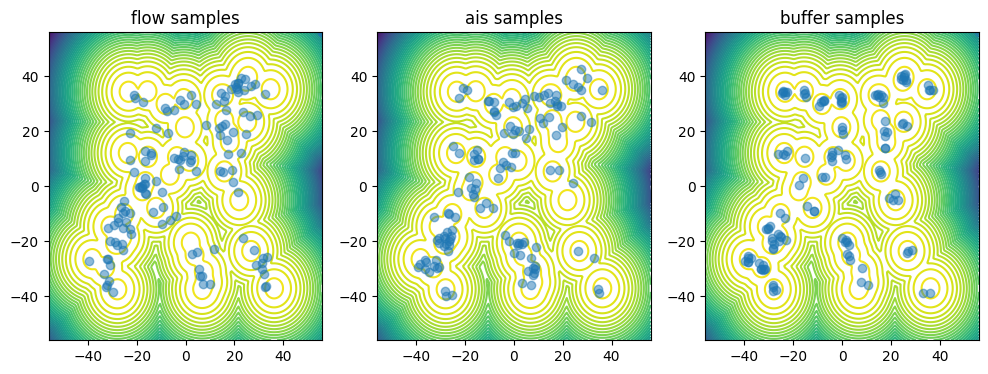

loss: 9.589736075521525, ess base: 0.4125346612020765,ess ais: 0.16966533345661325: 100%|██████████| 4000/4000 [03:50<00:00, 17.32it/s]

Timelimit not set


In [15]:
# Now run!
trainer.run(n_iterations=n_iterations, batch_size=batch_size, n_plot=n_plots, \
            n_eval=n_eval, eval_batch_size=eval_batch_size, save=False)  # note that the progress bar during training prints ESS w.r.t p^2/q. 

In the below plot of samples from the flow vs the target contours, and with the test set log prob throughout training, we see that the flow covers the target distribution quite well. It may be trained further to obtain even better results. 

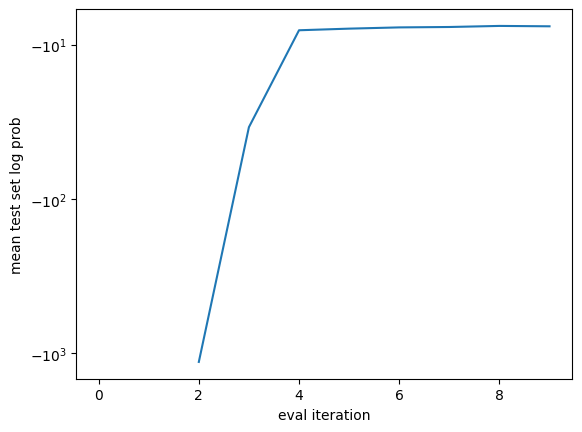

In [16]:
# Test set probability using samples from the target distribution.
eval_iters = np.linspace(0, n_iterations, n_eval)
plt.plot(logger.history['flow_test_set_mean_log_prob_p_target'])
plt.ylabel("mean test set log prob")
plt.xlabel("eval iteration")
plt.yscale("symlog")

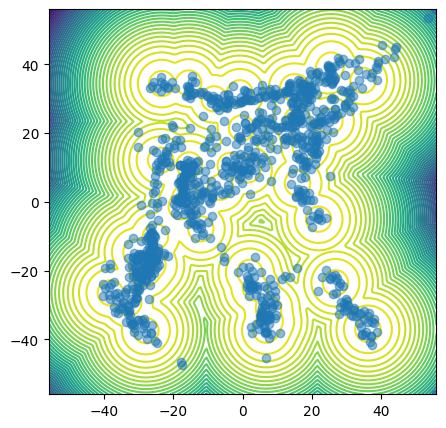

In [17]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
target.to("cpu")
plot_contours(target.log_prob, bounds=plotting_bounds, ax=axs, n_contour_levels=50, grid_width_n_points=200)
target.to("cuda")

n_samples = 1000
samples_flow = fab_model.flow.sample((n_samples,)).detach()
plot_marginal_pair(samples_flow, ax=axs, bounds=plotting_bounds)

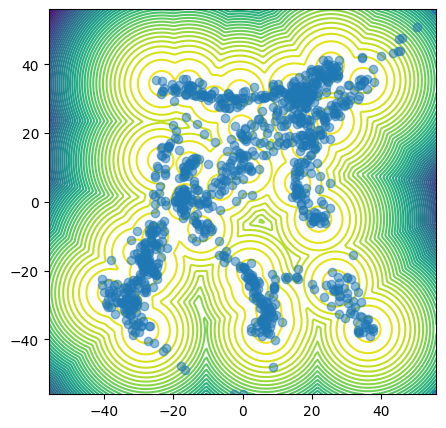

In [18]:
import scipy.stats.qmc as qmc
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
target.to("cpu")
plot_contours(target.log_prob, bounds=plotting_bounds, ax=axs, n_contour_levels=50, grid_width_n_points=200)
target.to("cuda")
gauss_flow = fab_model.flow._nf_model.q0
mean = gauss_flow.loc.data.cpu().numpy()[0]
scale = np.diag(np.exp(gauss_flow.log_scale.data.cpu().numpy())[0])

cov = None
# sample_qmc = qmc.MultivariateNormalQMC(mean = mean,cov = scale).random(1024)
# sample_qmc_cuda = torch.tensor(sample_qmc)
# samples_flow_qmc = fab_model.flow._nf_model.forward(sample_qmc_cuda).detach()
samples, log_q = fab_model.flow.sample_and_log_prob((1024, ))

plot_marginal_pair(samples, ax=axs, bounds=plotting_bounds)

In [19]:
def evaluate_qmc(funs,n_repeats=10): 
    """Evaluate by estimating quadratic function. If `path_to_model==target` then this is done
    using samples from the target"""
    biases = []
    biases_unweighted = []
    num_samples = 2**16
    mean_list = []
    list_dict = []
    for i in trange(n_repeats):
        model = fab_model
        samples, log_q = model.flow.sample_and_log_prob_qmc((num_samples, ),seed = i+1000)
        log_w = target.log_prob(samples) - log_q
        valid_indices = ~torch.isinf(log_w) & ~torch.isnan(log_w)
        samples, log_w = samples[valid_indices], log_w[valid_indices]
        valid_indices_unweighted = ~ (torch.softmax(log_w, axis=0) == 0)
        samples_unweighted = samples[valid_indices_unweighted]
        log_w_unweighted = torch.ones_like(log_w[valid_indices_unweighted])
        normed_bias = target.evaluate_expectation(samples, log_w).detach().cpu()
        normed_bias_unweighted = target.evaluate_expectation(samples_unweighted,
                                                             log_w_unweighted).detach().cpu()
        biases.append(normed_bias)
        biases_unweighted.append(normed_bias_unweighted)
        for fun,name in funs:
            mean = torch.mean(fun(samples)*torch.exp(log_w))
            list_dict.append({"value":float(mean.detach().cpu().numpy()), "function": name,"iter": i,"method": "qmc"})
        mean_list.append(mean.detach().cpu().numpy())
    info = {"bias": np.mean(np.abs(biases)),
            "std": np.std(biases),
            "bias_unweighted": np.mean(np.abs(biases_unweighted)),
            "df": list_dict}
    return info
funs = [(lambda x :x[:,0],"x[0]"), (lambda x :x[:,1],"x[1]"), (lambda x :x[:,0]**2,"x[0]**2"), (lambda x :x[:,1]**6,"x[1]**6"), (lambda x :x[:,0]*x[:,1],"cov"),(lambda x: torch.sin(x[:,0])*torch.cos(-x[:,1]/10),"sincos"), (lambda x: (x[:,0]>30)*1.0,"indi")]
u0 = evaluate_qmc(funs,200)

100%|██████████| 200/200 [07:03<00:00,  2.12s/it]


In [20]:
def evaluate(funs,n_repeats=10): 
    """Evaluate by estimating quadratic function. If `path_to_model==target` then this is done
    using samples from the target"""
    biases = []
    biases_unweighted = []
    num_samples = 2**16
    mean_list = []
    list_dict = []
    for i in trange(n_repeats):
        model = fab_model
        samples, log_q = model.flow.sample_and_log_prob((num_samples, ))
        log_w = target.log_prob(samples) - log_q
        valid_indices = ~torch.isinf(log_w) & ~torch.isnan(log_w)
        samples, log_w = samples[valid_indices], log_w[valid_indices]
        valid_indices_unweighted = ~ (torch.softmax(log_w, axis=0) == 0)
        samples_unweighted = samples[valid_indices_unweighted]
        log_w_unweighted = torch.ones_like(log_w[valid_indices_unweighted])
        normed_bias = target.evaluate_expectation(samples, log_w).detach().cpu()
        normed_bias_unweighted = target.evaluate_expectation(samples_unweighted,
                                                             log_w_unweighted).detach().cpu()
        biases.append(normed_bias)
        biases_unweighted.append(normed_bias_unweighted)

        for fun,name in funs:
            mean = torch.mean(fun(samples)*torch.exp(log_w))
            list_dict.append({"value":float(mean.detach().cpu().numpy()), "function": name,"iter": i,"method": "mc"})
        mean_list.append(mean.detach().cpu().numpy())
    info = {"bias": np.mean(np.abs(biases)),
            "std": np.std(biases),
            "bias_unweighted": np.mean(np.abs(biases_unweighted)),
            "df": list_dict}
    return info

u1 = evaluate(funs, 200)


100%|██████████| 200/200 [01:33<00:00,  2.14it/s]


/Users/andral/.pyenv/versions/3.10.12/envs/QMC_flow_AISTATS/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/andral/.pyenv/versions/3.10.12/envs/QMC_flow_AISTATS/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/andral/.pyenv/versions/3.10.12/envs/QMC_flow_AISTATS/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/andral/.pyenv/versions/3.10.12/envs/QMC_flow_AISTATS/lib/python3.10/site-packages/seabo

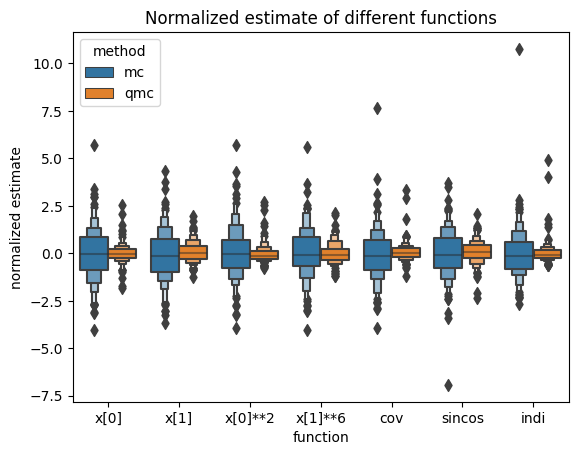

In [26]:
import pandas as pd
import seaborn as sns
df = pd.DataFrame(u1["df"] + u0["df"])
df["newcol"] = df.groupby(["function"])["value"].transform(lambda x : (x- x.mean())/ x.std())
sns.boxenplot(x="function", y="newcol", hue = "method",data=df)
plt.ylabel("normalized estimate")
plt.title("Normalized estimate of different functions")
plt.savefig("/Users/andral/Code/QMC_flow_AISTATS/Latex/normalized_estimate.pdf")

In [36]:
u = df[df["method"] == "mc"].groupby(["function"])["value"].std() / df[df.method == "qmc"].groupby(["function"])["value"].std()

In [43]:
print(u.to_frame().T.to_latex(index=False, float_format="%.3f"))

\begin{tabular}{rrrrrrr}
\toprule
cov & indi & sincos & x[0] & x[0]**2 & x[1] & x[1]**6 \\
\midrule
2.829 & 2.285 & 2.182 & 2.787 & 2.757 & 2.465 & 2.374 \\
\bottomrule
\end{tabular}



In [ ]:
\begin{tabular}{r}
\toprule
value \\
\midrule
2.829433 \\
2.284978 \\
2.182106 \\
2.786902 \\
2.756555 \\
2.464934 \\
2.373755 \\
\bottomrule
\end{tabular}

In [ ]:
u1=fab_model.annealed_importance_sampler.sample_and_log_weights_qmc(2**10)
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
plot_contours(target.log_prob, bounds=plotting_bounds, n_contour_levels=50, grid_width_n_points=200, ax=axs)
plot_marginal_pair(u1[0].x, bounds=plotting_bounds, ax=axs)
print(fab_model.annealed_importance_sampler._logging_info)

fig, axs = plt.subplots(1, 1, figsize=(5, 5))
u2 =fab_model.annealed_importance_sampler.sample_and_log_weights(2**10)
plot_marginal_pair(u2[0].x, bounds=plotting_bounds, ax=axs)
plot_contours(target.log_prob, bounds=plotting_bounds, n_contour_levels=50, grid_width_n_points=200, ax=axs)
